In [64]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
import sklearn
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [170]:
#1. Get the data and get it ready to use (delete useless columns, change categories values)

df=pd.read_csv("./challenge_youtube_toxic.csv", sep=";",encoding = 'latin1')
df=df.drop(['video_id','video_id_court','channel_id','channel_name','Unnamed: 27','nbrMotInsulteMoyenne'],axis=1)

'''
The categories-fields are useful data for us to analyse, 
but we cannot leave them as they are to compute a neural network algorithm.
We are then going to create one column for each value, and fill it with 0 or 1
'''

df['Core']=(df['categorie_new']=='Core')*1
df['Niche']=(df['categorie_new']=='Niche')*1
df['Partisan']=(df['categorie_new']=='Partisan')*1
df['Pure Players']=(df['categ_inst']=='Pure Players')*1
df['TV']=(df['categ_inst']=='TV')*1
df['Presse_regionale']=(df['categ_inst']=='Presse_regionale')*1
df['Presse nationale']=(df['categ_inst']=='Presse nationale')*1
df['Presse magazine']=(df['categ_inst']=='Presse magazine')*1
df['Alternatif']=(df['categ_inst']=='Alternatif')*1

df=df.drop(['categ_inst','categorie_new'],axis=1)

def convert_into_float(string):
    if type(string)==int:
        return string
    return float(string.replace(',','.'))

df=df.applymap(convert_into_float)

In [171]:
#2. Separate the train and the validation datasets
y=df['nbrMotInsulte'].to_numpy()
x=df.drop(['nbrMotInsulte'],axis=1).to_numpy()

X_train, X_val, y_train, y_val = train_test_split(x, y)

In [174]:
#3. Feature Scaling
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)

print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [358]:
#4. Setting up the model
num_features=x.shape[1]
hidden_layers=x.shape[0]/(num_features+1)

model = Sequential()
model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(hidden_layers, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_79 (Dense)             (None, 1589)              46081     
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 1590      
Total params: 48,483
Trainable params: 48,483
Non-trainable params: 0
_________________________________________________________________


In [359]:
epoch = 30
batch = 150
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

Epoch 1/30
185/185 [==============================] - 0s 2ms/step - loss: 5.0100e-05 - mse: 5.0100e-05 - mae: 0.0026 - val_loss: 8.2606e-05 - val_mse: 8.2606e-05 - val_mae: 0.0014
Epoch 2/30
185/185 [==============================] - 0s 2ms/step - loss: 1.9641e-05 - mse: 1.9641e-05 - mae: 0.0013 - val_loss: 2.9712e-05 - val_mse: 2.9712e-05 - val_mae: 0.0013
Epoch 3/30
185/185 [==============================] - 0s 2ms/step - loss: 1.4663e-05 - mse: 1.4663e-05 - mae: 0.0013 - val_loss: 1.5196e-05 - val_mse: 1.5196e-05 - val_mae: 8.9784e-04
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 1.2430e-05 - mse: 1.2430e-05 - mae: 0.0013 - val_loss: 1.0022e-04 - val_mse: 1.0022e-04 - val_mae: 0.0042
Epoch 5/30
185/185 [==============================] - 0s 2ms/step - loss: 1.5873e-05 - mse: 1.5873e-05 - mae: 0.0016 - val_loss: 1.2728e-05 - val_mse: 1.2728e-05 - val_mae: 0.0014
Epoch 6/30
185/185 [==============================] - 0s 2ms/step - loss: 1.1857e-05 - mse: 1.18

1195.433947227714

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


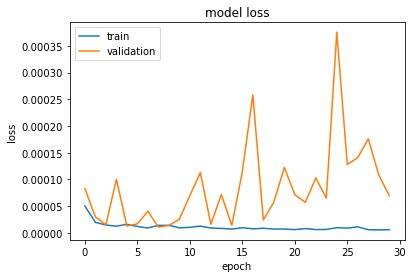

In [360]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [176]:
# Running the model
# We want to select the best couple (epoch, batch), so we test and compute the results for several different values
L_epoch=[30,50,100,200]
L_batch=[100,150,200,300,500]
History_dict={}
Prediction_dict={}
for epoch in L_epoch:
    History_dict[epoch]={}
    Prediction_dict[epoch]={}
    for batch in L_batch:
        model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
        history=model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.2)
        predictions = model.predict(xval_scale)
        
        History_dict[epoch][batch]=history
        Prediction_dict[epoch][batch]=predictions

Epoch 1/30
277/277 [==============================] - 0s 2ms/step - loss: 4.9665e-05 - mse: 4.9665e-05 - mae: 0.0026 - val_loss: 1.3371e-04 - val_mse: 1.3371e-04 - val_mae: 0.0018
Epoch 2/30
277/277 [==============================] - 0s 1ms/step - loss: 2.1539e-05 - mse: 2.1539e-05 - mae: 0.0016 - val_loss: 4.7263e-05 - val_mse: 4.7263e-05 - val_mae: 0.0023
Epoch 3/30
277/277 [==============================] - 0s 1ms/step - loss: 1.6188e-05 - mse: 1.6188e-05 - mae: 0.0014 - val_loss: 1.6902e-05 - val_mse: 1.6902e-05 - val_mae: 0.0010
Epoch 4/30
277/277 [==============================] - 0s 1ms/step - loss: 1.2948e-05 - mse: 1.2948e-05 - mae: 0.0014 - val_loss: 5.2650e-05 - val_mse: 5.2650e-05 - val_mae: 0.0027
Epoch 5/30
277/277 [==============================] - 0s 1ms/step - loss: 1.4755e-05 - mse: 1.4755e-05 - mae: 0.0015 - val_loss: 9.5894e-06 - val_mse: 9.5894e-06 - val_mae: 0.0010
Epoch 6/30
277/277 [==============================] - 0s 1ms/step - loss: 1.2638e-05 - mse: 1.2638e-

185/185 [==============================] - 0s 2ms/step - loss: 4.4234e-06 - mse: 4.4234e-06 - mae: 7.2881e-04 - val_loss: 2.2122e-04 - val_mse: 2.2122e-04 - val_mae: 7.9132e-04
Epoch 16/30
185/185 [==============================] - 0s 2ms/step - loss: 4.2129e-06 - mse: 4.2129e-06 - mae: 7.0641e-04 - val_loss: 1.3955e-04 - val_mse: 1.3955e-04 - val_mae: 8.0689e-04
Epoch 17/30
185/185 [==============================] - 0s 2ms/step - loss: 4.3623e-06 - mse: 4.3623e-06 - mae: 7.1993e-04 - val_loss: 1.2479e-04 - val_mse: 1.2479e-04 - val_mae: 9.1788e-04
Epoch 18/30
185/185 [==============================] - 0s 2ms/step - loss: 4.2344e-06 - mse: 4.2344e-06 - mae: 7.3534e-04 - val_loss: 2.0481e-04 - val_mse: 2.0481e-04 - val_mae: 9.7115e-04
Epoch 19/30
185/185 [==============================] - 0s 2ms/step - loss: 4.0427e-06 - mse: 4.0427e-06 - mae: 6.9476e-04 - val_loss: 1.1003e-04 - val_mse: 1.1003e-04 - val_mae: 0.0013
Epoch 20/30
185/185 [==============================] - 0s 2ms/step - lo

Epoch 29/30
139/139 [==============================] - 0s 2ms/step - loss: 3.6309e-06 - mse: 3.6309e-06 - mae: 6.8053e-04 - val_loss: 1.8162e-04 - val_mse: 1.8162e-04 - val_mae: 9.5319e-04
Epoch 30/30
139/139 [==============================] - 0s 1ms/step - loss: 4.0911e-06 - mse: 4.0911e-06 - mae: 7.4045e-04 - val_loss: 1.3223e-04 - val_mse: 1.3223e-04 - val_mae: 8.6170e-04
Epoch 1/30
93/93 [==============================] - 0s 4ms/step - loss: 3.7359e-06 - mse: 3.7359e-06 - mae: 6.5043e-04 - val_loss: 7.9994e-05 - val_mse: 7.9994e-05 - val_mae: 7.7745e-04
Epoch 2/30
93/93 [==============================] - 0s 3ms/step - loss: 3.3431e-06 - mse: 3.3431e-06 - mae: 5.8934e-04 - val_loss: 1.0330e-04 - val_mse: 1.0330e-04 - val_mae: 7.6854e-04
Epoch 3/30
93/93 [==============================] - 0s 3ms/step - loss: 3.3120e-06 - mse: 3.3120e-06 - mae: 6.4489e-04 - val_loss: 1.1613e-04 - val_mse: 1.1613e-04 - val_mae: 7.3740e-04
Epoch 4/30
93/93 [==============================] - 0s 3ms/step 

Epoch 13/30
56/56 [==============================] - 0s 4ms/step - loss: 2.8063e-06 - mse: 2.8063e-06 - mae: 5.3474e-04 - val_loss: 7.4291e-05 - val_mse: 7.4291e-05 - val_mae: 6.5194e-04
Epoch 14/30
56/56 [==============================] - 0s 4ms/step - loss: 2.7282e-06 - mse: 2.7282e-06 - mae: 5.4084e-04 - val_loss: 9.1396e-05 - val_mse: 9.1396e-05 - val_mae: 7.2668e-04
Epoch 15/30
56/56 [==============================] - 0s 4ms/step - loss: 2.7685e-06 - mse: 2.7685e-06 - mae: 5.5502e-04 - val_loss: 1.0523e-04 - val_mse: 1.0523e-04 - val_mae: 7.2849e-04
Epoch 16/30
56/56 [==============================] - 0s 4ms/step - loss: 2.8230e-06 - mse: 2.8230e-06 - mae: 5.9255e-04 - val_loss: 6.9744e-05 - val_mse: 6.9744e-05 - val_mae: 7.9738e-04
Epoch 17/30
56/56 [==============================] - 0s 4ms/step - loss: 2.8495e-06 - mse: 2.8495e-06 - mae: 5.6678e-04 - val_loss: 1.0654e-04 - val_mse: 1.0654e-04 - val_mae: 7.6766e-04
Epoch 18/30
56/56 [==============================] - 0s 4ms/step 

Epoch 27/50
277/277 [==============================] - 0s 1ms/step - loss: 4.1299e-06 - mse: 4.1299e-06 - mae: 6.5171e-04 - val_loss: 5.1852e-05 - val_mse: 5.1852e-05 - val_mae: 8.8944e-04
Epoch 28/50
277/277 [==============================] - 0s 1ms/step - loss: 3.2767e-06 - mse: 3.2767e-06 - mae: 6.6835e-04 - val_loss: 5.6540e-05 - val_mse: 5.6540e-05 - val_mae: 9.2448e-04
Epoch 29/50
277/277 [==============================] - 0s 1ms/step - loss: 3.1244e-06 - mse: 3.1244e-06 - mae: 6.3366e-04 - val_loss: 1.0226e-04 - val_mse: 1.0226e-04 - val_mae: 7.3589e-04
Epoch 30/50
277/277 [==============================] - 0s 1ms/step - loss: 3.1430e-06 - mse: 3.1430e-06 - mae: 6.3040e-04 - val_loss: 4.9144e-05 - val_mse: 4.9144e-05 - val_mae: 9.3643e-04
Epoch 31/50
277/277 [==============================] - 0s 1ms/step - loss: 3.2010e-06 - mse: 3.2010e-06 - mae: 6.7052e-04 - val_loss: 4.1743e-05 - val_mse: 4.1743e-05 - val_mae: 7.6501e-04
Epoch 32/50
277/277 [==============================] - 

185/185 [==============================] - 0s 1ms/step - loss: 3.3573e-06 - mse: 3.3573e-06 - mae: 6.5614e-04 - val_loss: 4.3155e-05 - val_mse: 4.3155e-05 - val_mae: 7.0221e-04
Epoch 21/50
185/185 [==============================] - 0s 1ms/step - loss: 3.2817e-06 - mse: 3.2817e-06 - mae: 6.3780e-04 - val_loss: 3.3680e-05 - val_mse: 3.3680e-05 - val_mae: 6.3648e-04
Epoch 22/50
185/185 [==============================] - 0s 1ms/step - loss: 2.8037e-06 - mse: 2.8037e-06 - mae: 6.1385e-04 - val_loss: 4.5084e-05 - val_mse: 4.5084e-05 - val_mae: 7.2804e-04
Epoch 23/50
185/185 [==============================] - 0s 1ms/step - loss: 2.8343e-06 - mse: 2.8343e-06 - mae: 6.1885e-04 - val_loss: 3.1809e-05 - val_mse: 3.1809e-05 - val_mae: 6.2727e-04
Epoch 24/50
185/185 [==============================] - 0s 1ms/step - loss: 2.7433e-06 - mse: 2.7433e-06 - mae: 6.0351e-04 - val_loss: 4.6938e-05 - val_mse: 4.6938e-05 - val_mae: 5.8955e-04
Epoch 25/50
185/185 [==============================] - 0s 1ms/step 

139/139 [==============================] - 0s 2ms/step - loss: 2.6828e-06 - mse: 2.6828e-06 - mae: 5.8309e-04 - val_loss: 3.3831e-05 - val_mse: 3.3831e-05 - val_mae: 6.0958e-04
Epoch 14/50
139/139 [==============================] - 0s 2ms/step - loss: 2.7746e-06 - mse: 2.7746e-06 - mae: 5.8989e-04 - val_loss: 2.3556e-05 - val_mse: 2.3556e-05 - val_mae: 5.9448e-04
Epoch 15/50
139/139 [==============================] - 0s 1ms/step - loss: 2.6464e-06 - mse: 2.6464e-06 - mae: 5.7876e-04 - val_loss: 4.2624e-05 - val_mse: 4.2624e-05 - val_mae: 6.9672e-04
Epoch 16/50
139/139 [==============================] - 0s 2ms/step - loss: 2.6400e-06 - mse: 2.6400e-06 - mae: 5.9301e-04 - val_loss: 5.1967e-05 - val_mse: 5.1967e-05 - val_mae: 6.0737e-04
Epoch 17/50
139/139 [==============================] - 0s 1ms/step - loss: 2.6512e-06 - mse: 2.6512e-06 - mae: 5.6789e-04 - val_loss: 4.8482e-05 - val_mse: 4.8482e-05 - val_mae: 6.1506e-04
Epoch 18/50
139/139 [==============================] - 0s 2ms/step 

93/93 [==============================] - 0s 3ms/step - loss: 2.6517e-06 - mse: 2.6517e-06 - mae: 5.4759e-04 - val_loss: 3.4909e-05 - val_mse: 3.4909e-05 - val_mae: 6.6639e-04
Epoch 7/50
93/93 [==============================] - 0s 3ms/step - loss: 2.5907e-06 - mse: 2.5907e-06 - mae: 5.6059e-04 - val_loss: 4.0212e-05 - val_mse: 4.0212e-05 - val_mae: 6.7320e-04
Epoch 8/50
93/93 [==============================] - 0s 3ms/step - loss: 2.5274e-06 - mse: 2.5274e-06 - mae: 5.4797e-04 - val_loss: 2.8548e-05 - val_mse: 2.8548e-05 - val_mae: 7.2638e-04
Epoch 9/50
93/93 [==============================] - 0s 3ms/step - loss: 2.5085e-06 - mse: 2.5085e-06 - mae: 5.3042e-04 - val_loss: 3.7638e-05 - val_mse: 3.7638e-05 - val_mae: 6.1498e-04
Epoch 10/50
93/93 [==============================] - 0s 3ms/step - loss: 2.5164e-06 - mse: 2.5164e-06 - mae: 5.5486e-04 - val_loss: 3.9215e-05 - val_mse: 3.9215e-05 - val_mae: 6.2290e-04
Epoch 11/50
93/93 [==============================] - 0s 3ms/step - loss: 2.5057e

Epoch 50/50
93/93 [==============================] - 0s 3ms/step - loss: 2.4343e-06 - mse: 2.4343e-06 - mae: 5.3404e-04 - val_loss: 2.0312e-05 - val_mse: 2.0312e-05 - val_mae: 5.9656e-04
Epoch 1/50
56/56 [==============================] - 0s 5ms/step - loss: 2.5059e-06 - mse: 2.5059e-06 - mae: 6.1284e-04 - val_loss: 3.0335e-05 - val_mse: 3.0335e-05 - val_mae: 5.9212e-04
Epoch 2/50
56/56 [==============================] - 0s 4ms/step - loss: 2.3028e-06 - mse: 2.3028e-06 - mae: 4.9194e-04 - val_loss: 3.1556e-05 - val_mse: 3.1556e-05 - val_mae: 6.8503e-04
Epoch 3/50
56/56 [==============================] - 0s 4ms/step - loss: 2.3503e-06 - mse: 2.3503e-06 - mae: 5.2603e-04 - val_loss: 3.3046e-05 - val_mse: 3.3046e-05 - val_mae: 6.4105e-04
Epoch 4/50
56/56 [==============================] - 0s 4ms/step - loss: 2.4201e-06 - mse: 2.4201e-06 - mae: 5.4207e-04 - val_loss: 4.5258e-05 - val_mse: 4.5258e-05 - val_mae: 6.0306e-04
Epoch 5/50
56/56 [==============================] - 0s 4ms/step - los

Epoch 44/50
56/56 [==============================] - 0s 4ms/step - loss: 2.3088e-06 - mse: 2.3088e-06 - mae: 5.2903e-04 - val_loss: 2.6297e-05 - val_mse: 2.6297e-05 - val_mae: 8.0256e-04
Epoch 45/50
56/56 [==============================] - 0s 4ms/step - loss: 2.4375e-06 - mse: 2.4375e-06 - mae: 5.7788e-04 - val_loss: 3.5931e-05 - val_mse: 3.5931e-05 - val_mae: 5.8243e-04
Epoch 46/50
56/56 [==============================] - 0s 4ms/step - loss: 2.2678e-06 - mse: 2.2678e-06 - mae: 5.0162e-04 - val_loss: 2.3208e-05 - val_mse: 2.3208e-05 - val_mae: 5.8758e-04
Epoch 47/50
56/56 [==============================] - 0s 4ms/step - loss: 2.3065e-06 - mse: 2.3065e-06 - mae: 5.4502e-04 - val_loss: 2.4000e-05 - val_mse: 2.4000e-05 - val_mae: 5.7424e-04
Epoch 48/50
56/56 [==============================] - 0s 4ms/step - loss: 2.2836e-06 - mse: 2.2836e-06 - mae: 5.0765e-04 - val_loss: 2.1472e-05 - val_mse: 2.1472e-05 - val_mae: 6.4290e-04
Epoch 49/50
56/56 [==============================] - 0s 4ms/step 

277/277 [==============================] - 0s 1ms/step - loss: 2.7222e-06 - mse: 2.7222e-06 - mae: 6.0686e-04 - val_loss: 4.7484e-05 - val_mse: 4.7484e-05 - val_mae: 7.4471e-04
Epoch 38/100
277/277 [==============================] - 0s 1ms/step - loss: 2.7292e-06 - mse: 2.7292e-06 - mae: 6.1673e-04 - val_loss: 2.3021e-05 - val_mse: 2.3021e-05 - val_mae: 5.9198e-04
Epoch 39/100
277/277 [==============================] - 0s 1ms/step - loss: 3.1215e-06 - mse: 3.1215e-06 - mae: 6.3669e-04 - val_loss: 1.7142e-05 - val_mse: 1.7142e-05 - val_mae: 6.9171e-04
Epoch 40/100
277/277 [==============================] - 0s 1ms/step - loss: 3.2055e-06 - mse: 3.2055e-06 - mae: 6.4452e-04 - val_loss: 8.0956e-06 - val_mse: 8.0956e-06 - val_mae: 9.8791e-04
Epoch 41/100
277/277 [==============================] - 0s 1ms/step - loss: 3.0212e-06 - mse: 3.0212e-06 - mae: 6.3604e-04 - val_loss: 1.7957e-05 - val_mse: 1.7957e-05 - val_mae: 6.5392e-04
Epoch 42/100
277/277 [==============================] - 0s 1ms/

277/277 [==============================] - 0s 1ms/step - loss: 2.4131e-06 - mse: 2.4131e-06 - mae: 5.7572e-04 - val_loss: 2.0951e-05 - val_mse: 2.0951e-05 - val_mae: 6.1234e-04
Epoch 81/100
277/277 [==============================] - 0s 1ms/step - loss: 2.6783e-06 - mse: 2.6783e-06 - mae: 5.7825e-04 - val_loss: 5.3375e-06 - val_mse: 5.3375e-06 - val_mae: 5.4426e-04
Epoch 82/100
277/277 [==============================] - 0s 1ms/step - loss: 3.2265e-06 - mse: 3.2265e-06 - mae: 6.4996e-04 - val_loss: 2.2978e-05 - val_mse: 2.2978e-05 - val_mae: 0.0011
Epoch 83/100
277/277 [==============================] - 0s 1ms/step - loss: 2.6905e-06 - mse: 2.6905e-06 - mae: 5.9914e-04 - val_loss: 2.2790e-05 - val_mse: 2.2790e-05 - val_mae: 6.4736e-04
Epoch 84/100
277/277 [==============================] - 0s 1ms/step - loss: 2.4935e-06 - mse: 2.4935e-06 - mae: 5.8829e-04 - val_loss: 2.6000e-05 - val_mse: 2.6000e-05 - val_mae: 6.5533e-04
Epoch 85/100
277/277 [==============================] - 0s 1ms/step

185/185 [==============================] - 0s 2ms/step - loss: 2.5834e-06 - mse: 2.5834e-06 - mae: 6.0237e-04 - val_loss: 2.3751e-05 - val_mse: 2.3751e-05 - val_mae: 5.9334e-04
Epoch 24/100
185/185 [==============================] - 0s 2ms/step - loss: 2.5146e-06 - mse: 2.5146e-06 - mae: 5.7221e-04 - val_loss: 1.4599e-05 - val_mse: 1.4599e-05 - val_mae: 6.5223e-04
Epoch 25/100
185/185 [==============================] - 0s 1ms/step - loss: 2.6916e-06 - mse: 2.6916e-06 - mae: 6.2057e-04 - val_loss: 1.0757e-05 - val_mse: 1.0757e-05 - val_mae: 6.3321e-04
Epoch 26/100
185/185 [==============================] - 0s 1ms/step - loss: 3.0787e-06 - mse: 3.0787e-06 - mae: 5.9982e-04 - val_loss: 1.0307e-04 - val_mse: 1.0307e-04 - val_mae: 7.5690e-04
Epoch 27/100
185/185 [==============================] - 0s 2ms/step - loss: 3.3055e-06 - mse: 3.3055e-06 - mae: 5.8847e-04 - val_loss: 2.3961e-05 - val_mse: 2.3961e-05 - val_mae: 9.5785e-04
Epoch 28/100
185/185 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 1ms/step - loss: 2.3941e-06 - mse: 2.3941e-06 - mae: 5.4315e-04 - val_loss: 2.4717e-05 - val_mse: 2.4717e-05 - val_mae: 6.1369e-04
Epoch 67/100
185/185 [==============================] - 0s 1ms/step - loss: 2.4248e-06 - mse: 2.4248e-06 - mae: 5.8835e-04 - val_loss: 1.7406e-05 - val_mse: 1.7406e-05 - val_mae: 5.4912e-04
Epoch 68/100
185/185 [==============================] - 0s 2ms/step - loss: 2.2742e-06 - mse: 2.2742e-06 - mae: 5.7848e-04 - val_loss: 1.6903e-05 - val_mse: 1.6903e-05 - val_mae: 6.6704e-04
Epoch 69/100
185/185 [==============================] - 0s 2ms/step - loss: 2.2769e-06 - mse: 2.2769e-06 - mae: 5.6591e-04 - val_loss: 1.5961e-05 - val_mse: 1.5961e-05 - val_mae: 8.1209e-04
Epoch 70/100
185/185 [==============================] - 0s 1ms/step - loss: 2.4677e-06 - mse: 2.4677e-06 - mae: 5.6807e-04 - val_loss: 2.3693e-05 - val_mse: 2.3693e-05 - val_mae: 6.5986e-04
Epoch 71/100
185/185 [==============================] - 0s 1ms/

139/139 [==============================] - 0s 2ms/step - loss: 2.1943e-06 - mse: 2.1943e-06 - mae: 5.4359e-04 - val_loss: 1.4895e-05 - val_mse: 1.4895e-05 - val_mae: 5.4479e-04
Epoch 10/100
139/139 [==============================] - 0s 1ms/step - loss: 2.3270e-06 - mse: 2.3270e-06 - mae: 5.4272e-04 - val_loss: 1.6635e-05 - val_mse: 1.6635e-05 - val_mae: 6.1788e-04
Epoch 11/100
139/139 [==============================] - 0s 2ms/step - loss: 2.1981e-06 - mse: 2.1981e-06 - mae: 5.2226e-04 - val_loss: 2.7540e-05 - val_mse: 2.7540e-05 - val_mae: 6.2496e-04
Epoch 12/100
139/139 [==============================] - 0s 2ms/step - loss: 2.3012e-06 - mse: 2.3012e-06 - mae: 5.4358e-04 - val_loss: 2.0081e-05 - val_mse: 2.0081e-05 - val_mae: 5.8609e-04
Epoch 13/100
139/139 [==============================] - 0s 1ms/step - loss: 2.2398e-06 - mse: 2.2398e-06 - mae: 5.3977e-04 - val_loss: 1.7807e-05 - val_mse: 1.7807e-05 - val_mae: 7.0885e-04
Epoch 14/100
139/139 [==============================] - 0s 2ms/

139/139 [==============================] - 0s 2ms/step - loss: 2.1933e-06 - mse: 2.1933e-06 - mae: 5.2412e-04 - val_loss: 1.8380e-05 - val_mse: 1.8380e-05 - val_mae: 6.6430e-04
Epoch 53/100
139/139 [==============================] - 0s 1ms/step - loss: 2.1770e-06 - mse: 2.1770e-06 - mae: 5.2186e-04 - val_loss: 1.1997e-05 - val_mse: 1.1997e-05 - val_mae: 5.8545e-04
Epoch 54/100
139/139 [==============================] - 0s 2ms/step - loss: 2.2541e-06 - mse: 2.2541e-06 - mae: 5.1362e-04 - val_loss: 1.0775e-05 - val_mse: 1.0775e-05 - val_mae: 8.2103e-04
Epoch 55/100
139/139 [==============================] - 0s 2ms/step - loss: 2.2511e-06 - mse: 2.2511e-06 - mae: 5.7009e-04 - val_loss: 1.3373e-05 - val_mse: 1.3373e-05 - val_mae: 6.4592e-04
Epoch 56/100
139/139 [==============================] - 0s 1ms/step - loss: 2.1991e-06 - mse: 2.1991e-06 - mae: 5.4556e-04 - val_loss: 1.9933e-05 - val_mse: 1.9933e-05 - val_mae: 7.2418e-04
Epoch 57/100
139/139 [==============================] - 0s 2ms/

139/139 [==============================] - 0s 2ms/step - loss: 2.0809e-06 - mse: 2.0809e-06 - mae: 5.2424e-04 - val_loss: 8.7996e-06 - val_mse: 8.7996e-06 - val_mae: 7.0167e-04
Epoch 96/100
139/139 [==============================] - 0s 2ms/step - loss: 2.1731e-06 - mse: 2.1731e-06 - mae: 5.2722e-04 - val_loss: 1.1900e-05 - val_mse: 1.1900e-05 - val_mae: 5.3415e-04
Epoch 97/100
139/139 [==============================] - 0s 2ms/step - loss: 2.1553e-06 - mse: 2.1553e-06 - mae: 5.2769e-04 - val_loss: 2.0533e-05 - val_mse: 2.0533e-05 - val_mae: 6.6027e-04
Epoch 98/100
139/139 [==============================] - 0s 1ms/step - loss: 2.4050e-06 - mse: 2.4050e-06 - mae: 5.7994e-04 - val_loss: 1.6069e-05 - val_mse: 1.6069e-05 - val_mae: 7.8926e-04
Epoch 99/100
139/139 [==============================] - 0s 2ms/step - loss: 2.2141e-06 - mse: 2.2141e-06 - mae: 5.4722e-04 - val_loss: 2.1769e-05 - val_mse: 2.1769e-05 - val_mae: 6.7407e-04
Epoch 100/100
139/139 [==============================] - 0s 2ms

Epoch 39/100
93/93 [==============================] - 0s 3ms/step - loss: 2.1613e-06 - mse: 2.1613e-06 - mae: 5.1354e-04 - val_loss: 7.3434e-06 - val_mse: 7.3434e-06 - val_mae: 7.0261e-04
Epoch 40/100
93/93 [==============================] - 0s 3ms/step - loss: 2.1993e-06 - mse: 2.1993e-06 - mae: 5.4954e-04 - val_loss: 1.4436e-05 - val_mse: 1.4436e-05 - val_mae: 6.8883e-04
Epoch 41/100
93/93 [==============================] - 0s 3ms/step - loss: 2.0827e-06 - mse: 2.0827e-06 - mae: 5.1315e-04 - val_loss: 1.1399e-05 - val_mse: 1.1399e-05 - val_mae: 6.4321e-04
Epoch 42/100
93/93 [==============================] - 0s 3ms/step - loss: 1.9987e-06 - mse: 1.9987e-06 - mae: 4.9088e-04 - val_loss: 9.8543e-06 - val_mse: 9.8543e-06 - val_mae: 8.6617e-04
Epoch 43/100
93/93 [==============================] - 0s 3ms/step - loss: 2.0483e-06 - mse: 2.0483e-06 - mae: 5.2730e-04 - val_loss: 1.3063e-05 - val_mse: 1.3063e-05 - val_mae: 6.0236e-04
Epoch 44/100
93/93 [==============================] - 0s 3ms

93/93 [==============================] - 0s 3ms/step - loss: 2.0279e-06 - mse: 2.0279e-06 - mae: 5.1518e-04 - val_loss: 1.3188e-05 - val_mse: 1.3188e-05 - val_mae: 6.0420e-04
Epoch 83/100
93/93 [==============================] - 0s 3ms/step - loss: 2.0789e-06 - mse: 2.0789e-06 - mae: 5.2167e-04 - val_loss: 1.3468e-05 - val_mse: 1.3468e-05 - val_mae: 6.5761e-04
Epoch 84/100
93/93 [==============================] - 0s 3ms/step - loss: 2.0358e-06 - mse: 2.0358e-06 - mae: 5.3269e-04 - val_loss: 1.3318e-05 - val_mse: 1.3318e-05 - val_mae: 6.3987e-04
Epoch 85/100
93/93 [==============================] - 0s 3ms/step - loss: 1.9763e-06 - mse: 1.9763e-06 - mae: 5.0386e-04 - val_loss: 1.4056e-05 - val_mse: 1.4056e-05 - val_mae: 5.8862e-04
Epoch 86/100
93/93 [==============================] - 0s 3ms/step - loss: 2.0081e-06 - mse: 2.0081e-06 - mae: 5.2275e-04 - val_loss: 1.4559e-05 - val_mse: 1.4559e-05 - val_mae: 6.0143e-04
Epoch 87/100
93/93 [==============================] - 0s 3ms/step - loss:

Epoch 26/100
56/56 [==============================] - 0s 4ms/step - loss: 1.9409e-06 - mse: 1.9409e-06 - mae: 5.0403e-04 - val_loss: 1.5066e-05 - val_mse: 1.5066e-05 - val_mae: 8.2595e-04
Epoch 27/100
56/56 [==============================] - 0s 4ms/step - loss: 1.9818e-06 - mse: 1.9818e-06 - mae: 4.9131e-04 - val_loss: 1.0785e-05 - val_mse: 1.0785e-05 - val_mae: 5.7966e-04
Epoch 28/100
56/56 [==============================] - 0s 4ms/step - loss: 1.9161e-06 - mse: 1.9161e-06 - mae: 4.9650e-04 - val_loss: 9.5093e-06 - val_mse: 9.5093e-06 - val_mae: 6.1916e-04
Epoch 29/100
56/56 [==============================] - 0s 4ms/step - loss: 1.9877e-06 - mse: 1.9877e-06 - mae: 5.2484e-04 - val_loss: 8.0033e-06 - val_mse: 8.0033e-06 - val_mae: 5.9282e-04
Epoch 30/100
56/56 [==============================] - 0s 4ms/step - loss: 1.9198e-06 - mse: 1.9198e-06 - mae: 4.8790e-04 - val_loss: 1.1329e-05 - val_mse: 1.1329e-05 - val_mae: 8.4379e-04
Epoch 31/100
56/56 [==============================] - 0s 4ms

56/56 [==============================] - 0s 4ms/step - loss: 2.0618e-06 - mse: 2.0618e-06 - mae: 5.1193e-04 - val_loss: 8.7880e-06 - val_mse: 8.7880e-06 - val_mae: 6.2299e-04
Epoch 70/100
56/56 [==============================] - 0s 4ms/step - loss: 2.4045e-06 - mse: 2.4045e-06 - mae: 5.7964e-04 - val_loss: 1.0817e-05 - val_mse: 1.0817e-05 - val_mae: 6.0444e-04
Epoch 71/100
56/56 [==============================] - 0s 4ms/step - loss: 2.0757e-06 - mse: 2.0757e-06 - mae: 5.2787e-04 - val_loss: 1.4828e-05 - val_mse: 1.4828e-05 - val_mae: 5.7904e-04
Epoch 72/100
56/56 [==============================] - 0s 4ms/step - loss: 2.0404e-06 - mse: 2.0404e-06 - mae: 5.1452e-04 - val_loss: 8.5830e-06 - val_mse: 8.5830e-06 - val_mae: 5.4642e-04
Epoch 73/100
56/56 [==============================] - 0s 4ms/step - loss: 1.9381e-06 - mse: 1.9381e-06 - mae: 5.0462e-04 - val_loss: 9.9980e-06 - val_mse: 9.9980e-06 - val_mae: 6.2993e-04
Epoch 74/100
56/56 [==============================] - 0s 4ms/step - loss:

277/277 [==============================] - 0s 1ms/step - loss: 2.2989e-06 - mse: 2.2989e-06 - mae: 5.7413e-04 - val_loss: 2.1776e-05 - val_mse: 2.1776e-05 - val_mae: 5.8383e-04
Epoch 13/200
277/277 [==============================] - 0s 1ms/step - loss: 2.1163e-06 - mse: 2.1163e-06 - mae: 5.4554e-04 - val_loss: 1.4288e-05 - val_mse: 1.4288e-05 - val_mae: 6.3430e-04
Epoch 14/200
277/277 [==============================] - 0s 1ms/step - loss: 2.0954e-06 - mse: 2.0954e-06 - mae: 5.5420e-04 - val_loss: 1.1389e-05 - val_mse: 1.1389e-05 - val_mae: 5.6250e-04
Epoch 15/200
277/277 [==============================] - 0s 1ms/step - loss: 2.1588e-06 - mse: 2.1588e-06 - mae: 5.5774e-04 - val_loss: 7.9442e-06 - val_mse: 7.9442e-06 - val_mae: 5.6950e-04
Epoch 16/200
277/277 [==============================] - 0s 1ms/step - loss: 2.2804e-06 - mse: 2.2804e-06 - mae: 5.6380e-04 - val_loss: 3.1006e-05 - val_mse: 3.1006e-05 - val_mae: 6.9968e-04
Epoch 17/200
277/277 [==============================] - 0s 1ms/

277/277 [==============================] - 0s 1ms/step - loss: 2.5361e-06 - mse: 2.5361e-06 - mae: 6.0517e-04 - val_loss: 6.8336e-06 - val_mse: 6.8336e-06 - val_mae: 6.9178e-04
Epoch 56/200
277/277 [==============================] - 0s 1ms/step - loss: 2.4514e-06 - mse: 2.4514e-06 - mae: 6.0189e-04 - val_loss: 7.2493e-06 - val_mse: 7.2493e-06 - val_mae: 6.9871e-04
Epoch 57/200
277/277 [==============================] - 0s 1ms/step - loss: 2.2367e-06 - mse: 2.2367e-06 - mae: 5.5886e-04 - val_loss: 8.1146e-06 - val_mse: 8.1146e-06 - val_mae: 6.4609e-04
Epoch 58/200
277/277 [==============================] - 0s 1ms/step - loss: 2.2202e-06 - mse: 2.2202e-06 - mae: 5.6508e-04 - val_loss: 7.7654e-06 - val_mse: 7.7654e-06 - val_mae: 6.3419e-04
Epoch 59/200
277/277 [==============================] - 0s 1ms/step - loss: 2.2648e-06 - mse: 2.2648e-06 - mae: 5.4503e-04 - val_loss: 1.5997e-05 - val_mse: 1.5997e-05 - val_mae: 6.6993e-04
Epoch 60/200
277/277 [==============================] - 0s 1ms/

277/277 [==============================] - 0s 1ms/step - loss: 2.3346e-06 - mse: 2.3346e-06 - mae: 5.6940e-04 - val_loss: 1.4272e-05 - val_mse: 1.4272e-05 - val_mae: 5.9234e-04
Epoch 99/200
277/277 [==============================] - 0s 1ms/step - loss: 2.3568e-06 - mse: 2.3568e-06 - mae: 6.0622e-04 - val_loss: 1.0877e-05 - val_mse: 1.0877e-05 - val_mae: 5.5645e-04
Epoch 100/200
277/277 [==============================] - 0s 1ms/step - loss: 2.2872e-06 - mse: 2.2872e-06 - mae: 5.6027e-04 - val_loss: 9.8987e-06 - val_mse: 9.8987e-06 - val_mae: 0.0010
Epoch 101/200
277/277 [==============================] - 0s 1ms/step - loss: 2.1361e-06 - mse: 2.1361e-06 - mae: 5.6406e-04 - val_loss: 7.9625e-06 - val_mse: 7.9625e-06 - val_mae: 5.3451e-04
Epoch 102/200
277/277 [==============================] - 0s 1ms/step - loss: 2.2975e-06 - mse: 2.2975e-06 - mae: 5.6509e-04 - val_loss: 7.2137e-06 - val_mse: 7.2137e-06 - val_mae: 6.5053e-04
Epoch 103/200
277/277 [==============================] - 0s 1ms/

Epoch 141/200
277/277 [==============================] - 0s 2ms/step - loss: 2.1013e-06 - mse: 2.1013e-06 - mae: 5.5541e-04 - val_loss: 6.5794e-06 - val_mse: 6.5794e-06 - val_mae: 5.6165e-04
Epoch 142/200
277/277 [==============================] - 0s 2ms/step - loss: 2.0878e-06 - mse: 2.0878e-06 - mae: 5.8504e-04 - val_loss: 6.2245e-06 - val_mse: 6.2245e-06 - val_mae: 7.4260e-04
Epoch 143/200
277/277 [==============================] - 0s 2ms/step - loss: 2.1473e-06 - mse: 2.1473e-06 - mae: 5.5138e-04 - val_loss: 1.3629e-05 - val_mse: 1.3629e-05 - val_mae: 5.7639e-04
Epoch 144/200
277/277 [==============================] - 0s 1ms/step - loss: 2.1340e-06 - mse: 2.1340e-06 - mae: 5.3788e-04 - val_loss: 6.4038e-06 - val_mse: 6.4038e-06 - val_mae: 5.6673e-04
Epoch 145/200
277/277 [==============================] - 0s 1ms/step - loss: 2.2886e-06 - mse: 2.2886e-06 - mae: 5.8003e-04 - val_loss: 1.5228e-05 - val_mse: 1.5228e-05 - val_mae: 6.7831e-04
Epoch 146/200
277/277 [======================

Epoch 184/200
277/277 [==============================] - 0s 1ms/step - loss: 2.0467e-06 - mse: 2.0467e-06 - mae: 5.5050e-04 - val_loss: 9.8432e-06 - val_mse: 9.8432e-06 - val_mae: 5.9402e-04
Epoch 185/200
277/277 [==============================] - 0s 1ms/step - loss: 2.3047e-06 - mse: 2.3047e-06 - mae: 5.9000e-04 - val_loss: 7.0819e-06 - val_mse: 7.0819e-06 - val_mae: 5.5092e-04
Epoch 186/200
277/277 [==============================] - 0s 1ms/step - loss: 2.5432e-06 - mse: 2.5432e-06 - mae: 5.7020e-04 - val_loss: 9.6748e-06 - val_mse: 9.6748e-06 - val_mae: 6.4542e-04
Epoch 187/200
277/277 [==============================] - 0s 1ms/step - loss: 2.1700e-06 - mse: 2.1700e-06 - mae: 5.4946e-04 - val_loss: 6.4476e-06 - val_mse: 6.4476e-06 - val_mae: 5.8401e-04
Epoch 188/200
277/277 [==============================] - 0s 1ms/step - loss: 2.1851e-06 - mse: 2.1851e-06 - mae: 5.4773e-04 - val_loss: 6.3155e-06 - val_mse: 6.3155e-06 - val_mae: 6.9728e-04
Epoch 189/200
277/277 [======================

185/185 [==============================] - 0s 2ms/step - loss: 2.2890e-06 - mse: 2.2890e-06 - mae: 5.4749e-04 - val_loss: 6.4680e-06 - val_mse: 6.4680e-06 - val_mae: 6.9804e-04
Epoch 28/200
185/185 [==============================] - 0s 1ms/step - loss: 2.0411e-06 - mse: 2.0411e-06 - mae: 5.4300e-04 - val_loss: 6.3647e-06 - val_mse: 6.3647e-06 - val_mae: 6.0496e-04
Epoch 29/200
185/185 [==============================] - 0s 1ms/step - loss: 2.0267e-06 - mse: 2.0267e-06 - mae: 5.3056e-04 - val_loss: 9.2376e-06 - val_mse: 9.2376e-06 - val_mae: 5.5038e-04
Epoch 30/200
185/185 [==============================] - 0s 1ms/step - loss: 2.0163e-06 - mse: 2.0163e-06 - mae: 5.2787e-04 - val_loss: 7.3030e-06 - val_mse: 7.3030e-06 - val_mae: 6.7002e-04
Epoch 31/200
185/185 [==============================] - 0s 1ms/step - loss: 1.9429e-06 - mse: 1.9429e-06 - mae: 5.2386e-04 - val_loss: 7.0352e-06 - val_mse: 7.0352e-06 - val_mae: 5.8871e-04
Epoch 32/200
185/185 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 1ms/step - loss: 1.9773e-06 - mse: 1.9773e-06 - mae: 5.3549e-04 - val_loss: 9.2779e-06 - val_mse: 9.2779e-06 - val_mae: 7.3878e-04
Epoch 71/200
185/185 [==============================] - 0s 1ms/step - loss: 1.9962e-06 - mse: 1.9962e-06 - mae: 5.2353e-04 - val_loss: 1.1732e-05 - val_mse: 1.1732e-05 - val_mae: 6.0373e-04
Epoch 72/200
185/185 [==============================] - 0s 1ms/step - loss: 2.7012e-06 - mse: 2.7012e-06 - mae: 5.9399e-04 - val_loss: 8.2143e-06 - val_mse: 8.2143e-06 - val_mae: 5.7068e-04
Epoch 73/200
185/185 [==============================] - 0s 1ms/step - loss: 2.1941e-06 - mse: 2.1941e-06 - mae: 5.6405e-04 - val_loss: 7.6461e-06 - val_mse: 7.6461e-06 - val_mae: 6.9863e-04
Epoch 74/200
185/185 [==============================] - 0s 1ms/step - loss: 2.0786e-06 - mse: 2.0786e-06 - mae: 5.4149e-04 - val_loss: 9.0954e-06 - val_mse: 9.0954e-06 - val_mae: 6.5625e-04
Epoch 75/200
185/185 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 1ms/step - loss: 2.2031e-06 - mse: 2.2031e-06 - mae: 5.4404e-04 - val_loss: 1.3946e-05 - val_mse: 1.3946e-05 - val_mae: 7.0857e-04
Epoch 114/200
185/185 [==============================] - 0s 1ms/step - loss: 2.6377e-06 - mse: 2.6377e-06 - mae: 5.5332e-04 - val_loss: 8.0593e-06 - val_mse: 8.0593e-06 - val_mae: 5.5263e-04
Epoch 115/200
185/185 [==============================] - 0s 1ms/step - loss: 1.9392e-06 - mse: 1.9392e-06 - mae: 5.1399e-04 - val_loss: 7.5543e-06 - val_mse: 7.5543e-06 - val_mae: 9.6090e-04
Epoch 116/200
185/185 [==============================] - 0s 1ms/step - loss: 1.9995e-06 - mse: 1.9995e-06 - mae: 5.2618e-04 - val_loss: 6.8646e-06 - val_mse: 6.8646e-06 - val_mae: 6.4559e-04
Epoch 117/200
185/185 [==============================] - 0s 1ms/step - loss: 1.9509e-06 - mse: 1.9509e-06 - mae: 5.1642e-04 - val_loss: 6.4703e-06 - val_mse: 6.4703e-06 - val_mae: 7.9521e-04
Epoch 118/200
185/185 [==============================] - 0s

Epoch 156/200
185/185 [==============================] - 0s 1ms/step - loss: 1.9634e-06 - mse: 1.9634e-06 - mae: 5.2009e-04 - val_loss: 7.0003e-06 - val_mse: 7.0003e-06 - val_mae: 6.3062e-04
Epoch 157/200
185/185 [==============================] - 0s 1ms/step - loss: 2.1107e-06 - mse: 2.1107e-06 - mae: 5.5712e-04 - val_loss: 7.6293e-06 - val_mse: 7.6293e-06 - val_mae: 9.0012e-04
Epoch 158/200
185/185 [==============================] - 0s 1ms/step - loss: 2.1947e-06 - mse: 2.1947e-06 - mae: 5.6044e-04 - val_loss: 8.5357e-06 - val_mse: 8.5357e-06 - val_mae: 7.0670e-04
Epoch 159/200
185/185 [==============================] - 0s 1ms/step - loss: 2.1009e-06 - mse: 2.1009e-06 - mae: 5.3633e-04 - val_loss: 6.6113e-06 - val_mse: 6.6113e-06 - val_mae: 5.3211e-04
Epoch 160/200
185/185 [==============================] - 0s 1ms/step - loss: 2.0048e-06 - mse: 2.0048e-06 - mae: 5.2992e-04 - val_loss: 7.3937e-06 - val_mse: 7.3937e-06 - val_mae: 5.3877e-04
Epoch 161/200
185/185 [======================

Epoch 199/200
185/185 [==============================] - 0s 1ms/step - loss: 2.0040e-06 - mse: 2.0040e-06 - mae: 5.3302e-04 - val_loss: 7.1683e-06 - val_mse: 7.1683e-06 - val_mae: 7.4758e-04
Epoch 200/200
185/185 [==============================] - 0s 1ms/step - loss: 2.3112e-06 - mse: 2.3112e-06 - mae: 5.8287e-04 - val_loss: 7.9385e-06 - val_mse: 7.9385e-06 - val_mae: 5.3689e-04
Epoch 1/200
139/139 [==============================] - 0s 2ms/step - loss: 1.9321e-06 - mse: 1.9321e-06 - mae: 5.4847e-04 - val_loss: 7.0682e-06 - val_mse: 7.0682e-06 - val_mae: 6.5093e-04
Epoch 2/200
139/139 [==============================] - 0s 2ms/step - loss: 1.8492e-06 - mse: 1.8492e-06 - mae: 4.9955e-04 - val_loss: 6.9032e-06 - val_mse: 6.9032e-06 - val_mae: 6.0454e-04
Epoch 3/200
139/139 [==============================] - 0s 2ms/step - loss: 1.8374e-06 - mse: 1.8374e-06 - mae: 5.1725e-04 - val_loss: 7.0589e-06 - val_mse: 7.0589e-06 - val_mae: 5.3222e-04
Epoch 4/200
139/139 [==============================

139/139 [==============================] - 0s 2ms/step - loss: 1.9303e-06 - mse: 1.9303e-06 - mae: 5.0487e-04 - val_loss: 7.5136e-06 - val_mse: 7.5136e-06 - val_mae: 7.9051e-04
Epoch 43/200
139/139 [==============================] - 0s 2ms/step - loss: 1.8205e-06 - mse: 1.8205e-06 - mae: 5.1669e-04 - val_loss: 7.5010e-06 - val_mse: 7.5010e-06 - val_mae: 8.1594e-04
Epoch 44/200
139/139 [==============================] - 0s 2ms/step - loss: 1.7132e-06 - mse: 1.7132e-06 - mae: 4.8428e-04 - val_loss: 7.3917e-06 - val_mse: 7.3917e-06 - val_mae: 6.4079e-04
Epoch 45/200
139/139 [==============================] - 0s 2ms/step - loss: 1.9162e-06 - mse: 1.9162e-06 - mae: 5.5554e-04 - val_loss: 8.5111e-06 - val_mse: 8.5111e-06 - val_mae: 7.5965e-04
Epoch 46/200
139/139 [==============================] - 0s 2ms/step - loss: 1.9618e-06 - mse: 1.9618e-06 - mae: 5.1860e-04 - val_loss: 9.1869e-06 - val_mse: 9.1869e-06 - val_mae: 5.6967e-04
Epoch 47/200
139/139 [==============================] - 0s 2ms/

139/139 [==============================] - 0s 2ms/step - loss: 1.9089e-06 - mse: 1.9089e-06 - mae: 5.3430e-04 - val_loss: 7.3681e-06 - val_mse: 7.3681e-06 - val_mae: 5.5664e-04
Epoch 86/200
139/139 [==============================] - 0s 2ms/step - loss: 1.7956e-06 - mse: 1.7956e-06 - mae: 5.0056e-04 - val_loss: 7.0587e-06 - val_mse: 7.0587e-06 - val_mae: 5.9260e-04
Epoch 87/200
139/139 [==============================] - 0s 2ms/step - loss: 1.8357e-06 - mse: 1.8357e-06 - mae: 5.4546e-04 - val_loss: 7.5938e-06 - val_mse: 7.5938e-06 - val_mae: 8.5183e-04
Epoch 88/200
139/139 [==============================] - 0s 2ms/step - loss: 1.7579e-06 - mse: 1.7579e-06 - mae: 5.0711e-04 - val_loss: 7.6748e-06 - val_mse: 7.6748e-06 - val_mae: 5.4831e-04
Epoch 89/200
139/139 [==============================] - 0s 2ms/step - loss: 1.8330e-06 - mse: 1.8330e-06 - mae: 5.2971e-04 - val_loss: 7.0898e-06 - val_mse: 7.0898e-06 - val_mae: 6.7166e-04
Epoch 90/200
139/139 [==============================] - 0s 2ms/

139/139 [==============================] - 0s 2ms/step - loss: 1.8163e-06 - mse: 1.8163e-06 - mae: 5.2011e-04 - val_loss: 7.9590e-06 - val_mse: 7.9590e-06 - val_mae: 6.0680e-04
Epoch 129/200
139/139 [==============================] - 0s 2ms/step - loss: 1.8052e-06 - mse: 1.8052e-06 - mae: 5.3773e-04 - val_loss: 8.0847e-06 - val_mse: 8.0847e-06 - val_mae: 6.1438e-04
Epoch 130/200
139/139 [==============================] - 0s 2ms/step - loss: 1.8490e-06 - mse: 1.8490e-06 - mae: 4.9298e-04 - val_loss: 8.6430e-06 - val_mse: 8.6430e-06 - val_mae: 5.8793e-04
Epoch 131/200
139/139 [==============================] - 0s 2ms/step - loss: 1.9992e-06 - mse: 1.9992e-06 - mae: 5.3434e-04 - val_loss: 9.8640e-06 - val_mse: 9.8640e-06 - val_mae: 9.0599e-04
Epoch 132/200
139/139 [==============================] - 0s 2ms/step - loss: 1.9405e-06 - mse: 1.9405e-06 - mae: 6.0152e-04 - val_loss: 8.0995e-06 - val_mse: 8.0995e-06 - val_mae: 6.5420e-04
Epoch 133/200
139/139 [==============================] - 0s

Epoch 171/200
139/139 [==============================] - 0s 1ms/step - loss: 1.8065e-06 - mse: 1.8065e-06 - mae: 5.3761e-04 - val_loss: 7.4800e-06 - val_mse: 7.4800e-06 - val_mae: 5.4059e-04
Epoch 172/200
139/139 [==============================] - 0s 2ms/step - loss: 1.8407e-06 - mse: 1.8407e-06 - mae: 5.2323e-04 - val_loss: 7.9021e-06 - val_mse: 7.9021e-06 - val_mae: 6.7111e-04
Epoch 173/200
139/139 [==============================] - 0s 2ms/step - loss: 1.7868e-06 - mse: 1.7868e-06 - mae: 5.0628e-04 - val_loss: 6.7260e-06 - val_mse: 6.7260e-06 - val_mae: 5.1601e-04
Epoch 174/200
139/139 [==============================] - 0s 2ms/step - loss: 1.8248e-06 - mse: 1.8248e-06 - mae: 5.1548e-04 - val_loss: 7.5271e-06 - val_mse: 7.5271e-06 - val_mae: 6.7610e-04
Epoch 175/200
139/139 [==============================] - 0s 2ms/step - loss: 1.7272e-06 - mse: 1.7272e-06 - mae: 4.9551e-04 - val_loss: 1.7111e-05 - val_mse: 1.7111e-05 - val_mae: 6.2440e-04
Epoch 176/200
139/139 [======================

93/93 [==============================] - 0s 3ms/step - loss: 1.9738e-06 - mse: 1.9738e-06 - mae: 5.3876e-04 - val_loss: 1.0368e-05 - val_mse: 1.0368e-05 - val_mae: 5.8184e-04
Epoch 15/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6734e-06 - mse: 1.6734e-06 - mae: 5.1062e-04 - val_loss: 9.6135e-06 - val_mse: 9.6135e-06 - val_mae: 5.9880e-04
Epoch 16/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6357e-06 - mse: 1.6357e-06 - mae: 4.6594e-04 - val_loss: 1.1571e-05 - val_mse: 1.1571e-05 - val_mae: 7.4596e-04
Epoch 17/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6243e-06 - mse: 1.6243e-06 - mae: 4.7624e-04 - val_loss: 9.7852e-06 - val_mse: 9.7852e-06 - val_mae: 6.4669e-04
Epoch 18/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6305e-06 - mse: 1.6305e-06 - mae: 4.7762e-04 - val_loss: 8.8915e-06 - val_mse: 8.8915e-06 - val_mae: 7.5202e-04
Epoch 19/200
93/93 [==============================] - 0s 3ms/step - loss:

Epoch 58/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6561e-06 - mse: 1.6561e-06 - mae: 4.7818e-04 - val_loss: 8.8489e-06 - val_mse: 8.8489e-06 - val_mae: 6.1009e-04
Epoch 59/200
93/93 [==============================] - 0s 3ms/step - loss: 1.7662e-06 - mse: 1.7662e-06 - mae: 5.0528e-04 - val_loss: 8.4754e-06 - val_mse: 8.4754e-06 - val_mae: 5.7822e-04
Epoch 60/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6191e-06 - mse: 1.6191e-06 - mae: 4.6884e-04 - val_loss: 9.9648e-06 - val_mse: 9.9648e-06 - val_mae: 5.5469e-04
Epoch 61/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6025e-06 - mse: 1.6025e-06 - mae: 4.7273e-04 - val_loss: 9.8044e-06 - val_mse: 9.8044e-06 - val_mae: 7.7466e-04
Epoch 62/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6492e-06 - mse: 1.6492e-06 - mae: 4.9154e-04 - val_loss: 1.0134e-05 - val_mse: 1.0134e-05 - val_mae: 5.8820e-04
Epoch 63/200
93/93 [==============================] - 0s 3ms

93/93 [==============================] - 0s 4ms/step - loss: 1.6311e-06 - mse: 1.6311e-06 - mae: 4.8717e-04 - val_loss: 1.0894e-05 - val_mse: 1.0894e-05 - val_mae: 7.0887e-04
Epoch 102/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6348e-06 - mse: 1.6348e-06 - mae: 4.8007e-04 - val_loss: 1.0189e-05 - val_mse: 1.0189e-05 - val_mae: 6.8372e-04
Epoch 103/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6798e-06 - mse: 1.6798e-06 - mae: 4.7910e-04 - val_loss: 9.7849e-06 - val_mse: 9.7849e-06 - val_mae: 5.6191e-04
Epoch 104/200
93/93 [==============================] - 0s 4ms/step - loss: 1.7027e-06 - mse: 1.7027e-06 - mae: 4.8631e-04 - val_loss: 1.3404e-05 - val_mse: 1.3404e-05 - val_mae: 5.5119e-04
Epoch 105/200
93/93 [==============================] - 0s 4ms/step - loss: 1.6421e-06 - mse: 1.6421e-06 - mae: 4.6897e-04 - val_loss: 1.0954e-05 - val_mse: 1.0954e-05 - val_mae: 7.3725e-04
Epoch 106/200
93/93 [==============================] - 0s 3ms/step - 

93/93 [==============================] - 0s 3ms/step - loss: 1.7584e-06 - mse: 1.7584e-06 - mae: 5.0388e-04 - val_loss: 9.9521e-06 - val_mse: 9.9521e-06 - val_mae: 6.0328e-04
Epoch 145/200
93/93 [==============================] - 0s 3ms/step - loss: 1.5994e-06 - mse: 1.5994e-06 - mae: 4.9295e-04 - val_loss: 1.0578e-05 - val_mse: 1.0578e-05 - val_mae: 5.9802e-04
Epoch 146/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6228e-06 - mse: 1.6228e-06 - mae: 4.8397e-04 - val_loss: 1.0374e-05 - val_mse: 1.0374e-05 - val_mae: 6.2368e-04
Epoch 147/200
93/93 [==============================] - 0s 3ms/step - loss: 1.5905e-06 - mse: 1.5905e-06 - mae: 4.6923e-04 - val_loss: 1.2179e-05 - val_mse: 1.2179e-05 - val_mae: 6.5607e-04
Epoch 148/200
93/93 [==============================] - 0s 3ms/step - loss: 1.7269e-06 - mse: 1.7269e-06 - mae: 4.9188e-04 - val_loss: 1.1094e-05 - val_mse: 1.1094e-05 - val_mae: 6.1737e-04
Epoch 149/200
93/93 [==============================] - 0s 3ms/step - 

93/93 [==============================] - 0s 3ms/step - loss: 1.6325e-06 - mse: 1.6325e-06 - mae: 4.9435e-04 - val_loss: 1.2219e-05 - val_mse: 1.2219e-05 - val_mae: 5.5366e-04
Epoch 188/200
93/93 [==============================] - 0s 3ms/step - loss: 1.5932e-06 - mse: 1.5932e-06 - mae: 4.9713e-04 - val_loss: 1.0013e-05 - val_mse: 1.0013e-05 - val_mae: 7.2676e-04
Epoch 189/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6178e-06 - mse: 1.6178e-06 - mae: 5.0041e-04 - val_loss: 1.2219e-05 - val_mse: 1.2219e-05 - val_mae: 6.7872e-04
Epoch 190/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6107e-06 - mse: 1.6107e-06 - mae: 4.6143e-04 - val_loss: 9.6203e-06 - val_mse: 9.6203e-06 - val_mae: 5.7062e-04
Epoch 191/200
93/93 [==============================] - 0s 3ms/step - loss: 1.6154e-06 - mse: 1.6154e-06 - mae: 4.8208e-04 - val_loss: 1.3524e-05 - val_mse: 1.3524e-05 - val_mae: 5.6423e-04
Epoch 192/200
93/93 [==============================] - 0s 3ms/step - 

Epoch 31/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5855e-06 - mse: 1.5855e-06 - mae: 4.7526e-04 - val_loss: 1.4566e-05 - val_mse: 1.4566e-05 - val_mae: 7.9480e-04
Epoch 32/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5862e-06 - mse: 1.5862e-06 - mae: 4.7188e-04 - val_loss: 1.2950e-05 - val_mse: 1.2950e-05 - val_mae: 5.6804e-04
Epoch 33/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5163e-06 - mse: 1.5163e-06 - mae: 4.6305e-04 - val_loss: 1.3282e-05 - val_mse: 1.3282e-05 - val_mae: 5.9663e-04
Epoch 34/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5265e-06 - mse: 1.5265e-06 - mae: 4.4487e-04 - val_loss: 1.1551e-05 - val_mse: 1.1551e-05 - val_mae: 6.6294e-04
Epoch 35/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5710e-06 - mse: 1.5710e-06 - mae: 4.7426e-04 - val_loss: 1.0769e-05 - val_mse: 1.0769e-05 - val_mae: 6.9793e-04
Epoch 36/200
56/56 [==============================] - 0s 4ms

56/56 [==============================] - 0s 4ms/step - loss: 1.5405e-06 - mse: 1.5405e-06 - mae: 4.6596e-04 - val_loss: 1.3403e-05 - val_mse: 1.3403e-05 - val_mae: 6.6412e-04
Epoch 75/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5238e-06 - mse: 1.5238e-06 - mae: 4.5408e-04 - val_loss: 1.3732e-05 - val_mse: 1.3732e-05 - val_mae: 5.8251e-04
Epoch 76/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5746e-06 - mse: 1.5746e-06 - mae: 4.8230e-04 - val_loss: 1.5044e-05 - val_mse: 1.5044e-05 - val_mae: 5.9482e-04
Epoch 77/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5579e-06 - mse: 1.5579e-06 - mae: 4.8119e-04 - val_loss: 1.1972e-05 - val_mse: 1.1972e-05 - val_mae: 6.0194e-04
Epoch 78/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5577e-06 - mse: 1.5577e-06 - mae: 4.6080e-04 - val_loss: 1.4210e-05 - val_mse: 1.4210e-05 - val_mae: 6.2299e-04
Epoch 79/200
56/56 [==============================] - 0s 4ms/step - loss:

56/56 [==============================] - 0s 4ms/step - loss: 1.5214e-06 - mse: 1.5214e-06 - mae: 4.4753e-04 - val_loss: 1.4120e-05 - val_mse: 1.4120e-05 - val_mae: 5.8517e-04
Epoch 118/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5253e-06 - mse: 1.5253e-06 - mae: 4.3278e-04 - val_loss: 1.4551e-05 - val_mse: 1.4551e-05 - val_mae: 5.9624e-04
Epoch 119/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5316e-06 - mse: 1.5316e-06 - mae: 4.6444e-04 - val_loss: 1.4870e-05 - val_mse: 1.4870e-05 - val_mae: 7.0833e-04
Epoch 120/200
56/56 [==============================] - 0s 4ms/step - loss: 1.6177e-06 - mse: 1.6177e-06 - mae: 4.9848e-04 - val_loss: 1.3142e-05 - val_mse: 1.3142e-05 - val_mae: 5.6059e-04
Epoch 121/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5247e-06 - mse: 1.5247e-06 - mae: 4.5756e-04 - val_loss: 1.3726e-05 - val_mse: 1.3726e-05 - val_mae: 7.0403e-04
Epoch 122/200
56/56 [==============================] - 0s 4ms/step - 

56/56 [==============================] - 0s 4ms/step - loss: 1.5348e-06 - mse: 1.5348e-06 - mae: 4.6430e-04 - val_loss: 1.4493e-05 - val_mse: 1.4493e-05 - val_mae: 5.6117e-04
Epoch 161/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5091e-06 - mse: 1.5091e-06 - mae: 4.4906e-04 - val_loss: 1.7232e-05 - val_mse: 1.7232e-05 - val_mae: 7.1599e-04
Epoch 162/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5531e-06 - mse: 1.5531e-06 - mae: 4.9060e-04 - val_loss: 1.2240e-05 - val_mse: 1.2240e-05 - val_mae: 6.0901e-04
Epoch 163/200
56/56 [==============================] - 0s 4ms/step - loss: 1.6114e-06 - mse: 1.6114e-06 - mae: 4.7682e-04 - val_loss: 1.8341e-05 - val_mse: 1.8341e-05 - val_mae: 5.7567e-04
Epoch 164/200
56/56 [==============================] - 0s 4ms/step - loss: 1.6196e-06 - mse: 1.6196e-06 - mae: 5.2023e-04 - val_loss: 1.6434e-05 - val_mse: 1.6434e-05 - val_mae: 7.3769e-04
Epoch 165/200
56/56 [==============================] - 0s 4ms/step - 

In [178]:
epoch=300
History_dict[epoch]={}
Prediction_dict[epoch]={}
for batch in L_batch:
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
    history=model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.2)
    predictions = model.predict(xval_scale)

    History_dict[epoch][batch]=history
    Prediction_dict[epoch][batch]=predictions

Epoch 1/300
277/277 [==============================] - 0s 2ms/step - loss: 1.8931e-06 - mse: 1.8931e-06 - mae: 5.6096e-04 - val_loss: 1.0789e-05 - val_mse: 1.0789e-05 - val_mae: 7.2865e-04
Epoch 2/300
277/277 [==============================] - 0s 1ms/step - loss: 1.9272e-06 - mse: 1.9272e-06 - mae: 5.7715e-04 - val_loss: 1.9857e-05 - val_mse: 1.9857e-05 - val_mae: 7.1842e-04
Epoch 3/300
277/277 [==============================] - 0s 1ms/step - loss: 2.0863e-06 - mse: 2.0863e-06 - mae: 6.0109e-04 - val_loss: 1.4549e-05 - val_mse: 1.4549e-05 - val_mae: 5.7350e-04
Epoch 4/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7655e-06 - mse: 1.7655e-06 - mae: 5.5291e-04 - val_loss: 8.7813e-06 - val_mse: 8.7813e-06 - val_mae: 7.6958e-04
Epoch 5/300
277/277 [==============================] - 0s 1ms/step - loss: 2.2694e-06 - mse: 2.2694e-06 - mae: 5.7148e-04 - val_loss: 2.0821e-05 - val_mse: 2.0821e-05 - val_mae: 7.6832e-04
Epoch 6/300
277/277 [==============================] - 

277/277 [==============================] - 0s 1ms/step - loss: 1.7623e-06 - mse: 1.7623e-06 - mae: 5.2206e-04 - val_loss: 1.4486e-05 - val_mse: 1.4486e-05 - val_mae: 6.1865e-04
Epoch 45/300
277/277 [==============================] - 0s 1ms/step - loss: 1.8007e-06 - mse: 1.8007e-06 - mae: 5.3019e-04 - val_loss: 1.4604e-05 - val_mse: 1.4604e-05 - val_mae: 5.7912e-04
Epoch 46/300
277/277 [==============================] - 0s 1ms/step - loss: 1.8162e-06 - mse: 1.8162e-06 - mae: 5.4250e-04 - val_loss: 8.9002e-06 - val_mse: 8.9002e-06 - val_mae: 5.8770e-04
Epoch 47/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7521e-06 - mse: 1.7521e-06 - mae: 5.4251e-04 - val_loss: 1.0823e-05 - val_mse: 1.0823e-05 - val_mae: 5.9839e-04
Epoch 48/300
277/277 [==============================] - 0s 1ms/step - loss: 1.8328e-06 - mse: 1.8328e-06 - mae: 5.1006e-04 - val_loss: 1.2631e-05 - val_mse: 1.2631e-05 - val_mae: 7.4000e-04
Epoch 49/300
277/277 [==============================] - 0s 1ms/

277/277 [==============================] - 0s 1ms/step - loss: 2.0912e-06 - mse: 2.0912e-06 - mae: 5.5906e-04 - val_loss: 1.1334e-05 - val_mse: 1.1334e-05 - val_mae: 6.0226e-04
Epoch 88/300
277/277 [==============================] - 0s 1ms/step - loss: 2.0967e-06 - mse: 2.0967e-06 - mae: 5.2587e-04 - val_loss: 8.4086e-06 - val_mse: 8.4086e-06 - val_mae: 6.1635e-04
Epoch 89/300
277/277 [==============================] - 0s 1ms/step - loss: 2.2316e-06 - mse: 2.2316e-06 - mae: 5.7119e-04 - val_loss: 1.7990e-05 - val_mse: 1.7990e-05 - val_mae: 7.7145e-04
Epoch 90/300
277/277 [==============================] - 0s 1ms/step - loss: 2.0864e-06 - mse: 2.0864e-06 - mae: 5.5652e-04 - val_loss: 1.1495e-05 - val_mse: 1.1495e-05 - val_mae: 8.2025e-04
Epoch 91/300
277/277 [==============================] - 0s 1ms/step - loss: 2.0098e-06 - mse: 2.0098e-06 - mae: 5.6352e-04 - val_loss: 9.4909e-06 - val_mse: 9.4909e-06 - val_mae: 7.0452e-04
Epoch 92/300
277/277 [==============================] - 0s 1ms/

277/277 [==============================] - 0s 1ms/step - loss: 1.9065e-06 - mse: 1.9065e-06 - mae: 5.5530e-04 - val_loss: 9.4178e-06 - val_mse: 9.4178e-06 - val_mae: 6.7736e-04
Epoch 131/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7317e-06 - mse: 1.7317e-06 - mae: 5.2636e-04 - val_loss: 9.6254e-06 - val_mse: 9.6254e-06 - val_mae: 8.9880e-04
Epoch 132/300
277/277 [==============================] - 0s 1ms/step - loss: 1.8205e-06 - mse: 1.8205e-06 - mae: 5.3277e-04 - val_loss: 9.0067e-06 - val_mse: 9.0067e-06 - val_mae: 6.7079e-04
Epoch 133/300
277/277 [==============================] - 0s 1ms/step - loss: 1.8237e-06 - mse: 1.8237e-06 - mae: 5.4449e-04 - val_loss: 9.6512e-06 - val_mse: 9.6512e-06 - val_mae: 7.5895e-04
Epoch 134/300
277/277 [==============================] - 0s 1ms/step - loss: 2.1892e-06 - mse: 2.1892e-06 - mae: 5.8476e-04 - val_loss: 7.5675e-06 - val_mse: 7.5675e-06 - val_mae: 5.9812e-04
Epoch 135/300
277/277 [==============================] - 0s

Epoch 173/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7692e-06 - mse: 1.7692e-06 - mae: 5.2595e-04 - val_loss: 7.2687e-06 - val_mse: 7.2687e-06 - val_mae: 6.1656e-04
Epoch 174/300
277/277 [==============================] - 0s 1ms/step - loss: 1.8249e-06 - mse: 1.8249e-06 - mae: 5.4262e-04 - val_loss: 8.9450e-06 - val_mse: 8.9450e-06 - val_mae: 8.6226e-04
Epoch 175/300
277/277 [==============================] - 0s 1ms/step - loss: 1.8033e-06 - mse: 1.8033e-06 - mae: 5.4985e-04 - val_loss: 1.3560e-05 - val_mse: 1.3560e-05 - val_mae: 6.8666e-04
Epoch 176/300
277/277 [==============================] - 0s 1ms/step - loss: 1.8620e-06 - mse: 1.8620e-06 - mae: 5.6182e-04 - val_loss: 1.1599e-05 - val_mse: 1.1599e-05 - val_mae: 7.3812e-04
Epoch 177/300
277/277 [==============================] - 0s 1ms/step - loss: 2.0459e-06 - mse: 2.0459e-06 - mae: 5.5095e-04 - val_loss: 1.5432e-05 - val_mse: 1.5432e-05 - val_mae: 7.1215e-04
Epoch 178/300
277/277 [======================

Epoch 216/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7409e-06 - mse: 1.7409e-06 - mae: 5.1320e-04 - val_loss: 9.8102e-06 - val_mse: 9.8102e-06 - val_mae: 6.4558e-04
Epoch 217/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7636e-06 - mse: 1.7636e-06 - mae: 5.2097e-04 - val_loss: 7.2936e-06 - val_mse: 7.2936e-06 - val_mae: 5.6651e-04
Epoch 218/300
277/277 [==============================] - 0s 1ms/step - loss: 1.9102e-06 - mse: 1.9102e-06 - mae: 5.3599e-04 - val_loss: 7.4229e-06 - val_mse: 7.4229e-06 - val_mae: 5.8971e-04
Epoch 219/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7121e-06 - mse: 1.7121e-06 - mae: 5.2819e-04 - val_loss: 8.0738e-06 - val_mse: 8.0738e-06 - val_mae: 7.2124e-04
Epoch 220/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7439e-06 - mse: 1.7439e-06 - mae: 5.2221e-04 - val_loss: 8.3939e-06 - val_mse: 8.3939e-06 - val_mae: 5.6248e-04
Epoch 221/300
277/277 [======================

Epoch 259/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7992e-06 - mse: 1.7992e-06 - mae: 5.0527e-04 - val_loss: 1.3153e-05 - val_mse: 1.3153e-05 - val_mae: 6.4419e-04
Epoch 260/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7912e-06 - mse: 1.7912e-06 - mae: 5.3248e-04 - val_loss: 9.0193e-06 - val_mse: 9.0193e-06 - val_mae: 5.7599e-04
Epoch 261/300
277/277 [==============================] - 0s 1ms/step - loss: 1.8318e-06 - mse: 1.8318e-06 - mae: 5.2965e-04 - val_loss: 8.7128e-06 - val_mse: 8.7128e-06 - val_mae: 6.6297e-04
Epoch 262/300
277/277 [==============================] - 0s 1ms/step - loss: 1.7800e-06 - mse: 1.7800e-06 - mae: 5.2951e-04 - val_loss: 7.8992e-06 - val_mse: 7.8992e-06 - val_mae: 6.3756e-04
Epoch 263/300
277/277 [==============================] - 0s 1ms/step - loss: 1.6705e-06 - mse: 1.6705e-06 - mae: 5.0508e-04 - val_loss: 8.2825e-06 - val_mse: 8.2825e-06 - val_mae: 5.7264e-04
Epoch 264/300
277/277 [======================

Epoch 2/300
185/185 [==============================] - 0s 1ms/step - loss: 1.7233e-06 - mse: 1.7233e-06 - mae: 5.1840e-04 - val_loss: 1.0568e-05 - val_mse: 1.0568e-05 - val_mae: 6.2401e-04
Epoch 3/300
185/185 [==============================] - 0s 1ms/step - loss: 1.7357e-06 - mse: 1.7357e-06 - mae: 5.1189e-04 - val_loss: 7.9858e-06 - val_mse: 7.9858e-06 - val_mae: 5.9392e-04
Epoch 4/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6122e-06 - mse: 1.6122e-06 - mae: 4.9371e-04 - val_loss: 7.6096e-06 - val_mse: 7.6096e-06 - val_mae: 6.2345e-04
Epoch 5/300
185/185 [==============================] - 0s 1ms/step - loss: 1.9185e-06 - mse: 1.9185e-06 - mae: 5.4612e-04 - val_loss: 9.3600e-06 - val_mse: 9.3600e-06 - val_mae: 6.3272e-04
Epoch 6/300
185/185 [==============================] - 0s 1ms/step - loss: 1.8024e-06 - mse: 1.8024e-06 - mae: 5.1835e-04 - val_loss: 8.9880e-06 - val_mse: 8.9880e-06 - val_mae: 6.1434e-04
Epoch 7/300
185/185 [==============================] - 

185/185 [==============================] - 0s 1ms/step - loss: 1.6861e-06 - mse: 1.6861e-06 - mae: 5.1083e-04 - val_loss: 8.0685e-06 - val_mse: 8.0685e-06 - val_mae: 7.6419e-04
Epoch 46/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6739e-06 - mse: 1.6739e-06 - mae: 5.0165e-04 - val_loss: 8.1222e-06 - val_mse: 8.1222e-06 - val_mae: 5.4692e-04
Epoch 47/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6214e-06 - mse: 1.6214e-06 - mae: 4.9394e-04 - val_loss: 8.6252e-06 - val_mse: 8.6252e-06 - val_mae: 7.2883e-04
Epoch 48/300
185/185 [==============================] - 0s 1ms/step - loss: 1.7386e-06 - mse: 1.7386e-06 - mae: 5.4031e-04 - val_loss: 8.5729e-06 - val_mse: 8.5729e-06 - val_mae: 5.7464e-04
Epoch 49/300
185/185 [==============================] - 0s 2ms/step - loss: 1.7842e-06 - mse: 1.7842e-06 - mae: 5.2095e-04 - val_loss: 7.9333e-06 - val_mse: 7.9333e-06 - val_mae: 5.3610e-04
Epoch 50/300
185/185 [==============================] - 0s 2ms/

185/185 [==============================] - 0s 1ms/step - loss: 1.6331e-06 - mse: 1.6331e-06 - mae: 5.0586e-04 - val_loss: 8.2113e-06 - val_mse: 8.2113e-06 - val_mae: 5.7356e-04
Epoch 89/300
185/185 [==============================] - 0s 1ms/step - loss: 2.2064e-06 - mse: 2.2064e-06 - mae: 5.5360e-04 - val_loss: 8.3300e-06 - val_mse: 8.3300e-06 - val_mae: 5.8933e-04
Epoch 90/300
185/185 [==============================] - 0s 1ms/step - loss: 1.8799e-06 - mse: 1.8799e-06 - mae: 5.3896e-04 - val_loss: 7.7779e-06 - val_mse: 7.7779e-06 - val_mae: 6.3594e-04
Epoch 91/300
185/185 [==============================] - 0s 2ms/step - loss: 1.8797e-06 - mse: 1.8797e-06 - mae: 5.4761e-04 - val_loss: 8.3643e-06 - val_mse: 8.3643e-06 - val_mae: 9.5597e-04
Epoch 92/300
185/185 [==============================] - 0s 1ms/step - loss: 1.7489e-06 - mse: 1.7489e-06 - mae: 5.3462e-04 - val_loss: 8.2626e-06 - val_mse: 8.2626e-06 - val_mae: 6.9013e-04
Epoch 93/300
185/185 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 2ms/step - loss: 1.6146e-06 - mse: 1.6146e-06 - mae: 4.7552e-04 - val_loss: 7.5111e-06 - val_mse: 7.5111e-06 - val_mae: 6.9449e-04
Epoch 132/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6316e-06 - mse: 1.6316e-06 - mae: 5.1270e-04 - val_loss: 8.2525e-06 - val_mse: 8.2525e-06 - val_mae: 5.6210e-04
Epoch 133/300
185/185 [==============================] - 0s 1ms/step - loss: 1.5854e-06 - mse: 1.5854e-06 - mae: 4.9997e-04 - val_loss: 8.7945e-06 - val_mse: 8.7945e-06 - val_mae: 5.7269e-04
Epoch 134/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6990e-06 - mse: 1.6990e-06 - mae: 5.6597e-04 - val_loss: 1.0337e-05 - val_mse: 1.0337e-05 - val_mae: 6.0862e-04
Epoch 135/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6808e-06 - mse: 1.6808e-06 - mae: 4.9906e-04 - val_loss: 7.9458e-06 - val_mse: 7.9458e-06 - val_mae: 6.6423e-04
Epoch 136/300
185/185 [==============================] - 0s

Epoch 174/300
185/185 [==============================] - 0s 1ms/step - loss: 1.8400e-06 - mse: 1.8400e-06 - mae: 5.2738e-04 - val_loss: 9.4325e-06 - val_mse: 9.4325e-06 - val_mae: 7.4082e-04
Epoch 175/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6789e-06 - mse: 1.6789e-06 - mae: 5.2230e-04 - val_loss: 7.8315e-06 - val_mse: 7.8315e-06 - val_mae: 6.2642e-04
Epoch 176/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6501e-06 - mse: 1.6501e-06 - mae: 5.1391e-04 - val_loss: 7.4124e-06 - val_mse: 7.4124e-06 - val_mae: 5.6368e-04
Epoch 177/300
185/185 [==============================] - 0s 1ms/step - loss: 1.5821e-06 - mse: 1.5821e-06 - mae: 5.1688e-04 - val_loss: 1.0340e-05 - val_mse: 1.0340e-05 - val_mae: 6.1466e-04
Epoch 178/300
185/185 [==============================] - 0s 1ms/step - loss: 1.8836e-06 - mse: 1.8836e-06 - mae: 5.4577e-04 - val_loss: 9.5175e-06 - val_mse: 9.5175e-06 - val_mae: 6.4552e-04
Epoch 179/300
185/185 [======================

Epoch 217/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6250e-06 - mse: 1.6250e-06 - mae: 4.9250e-04 - val_loss: 9.9998e-06 - val_mse: 9.9998e-06 - val_mae: 6.5999e-04
Epoch 218/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6776e-06 - mse: 1.6776e-06 - mae: 5.2728e-04 - val_loss: 8.1930e-06 - val_mse: 8.1930e-06 - val_mae: 6.4010e-04
Epoch 219/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6248e-06 - mse: 1.6248e-06 - mae: 5.3069e-04 - val_loss: 7.8804e-06 - val_mse: 7.8804e-06 - val_mae: 7.3526e-04
Epoch 220/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6804e-06 - mse: 1.6804e-06 - mae: 5.2833e-04 - val_loss: 8.3069e-06 - val_mse: 8.3069e-06 - val_mae: 5.4230e-04
Epoch 221/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6684e-06 - mse: 1.6684e-06 - mae: 4.9280e-04 - val_loss: 9.1838e-06 - val_mse: 9.1838e-06 - val_mae: 8.8640e-04
Epoch 222/300
185/185 [======================

Epoch 260/300
185/185 [==============================] - 0s 1ms/step - loss: 1.5975e-06 - mse: 1.5975e-06 - mae: 4.9424e-04 - val_loss: 9.0898e-06 - val_mse: 9.0898e-06 - val_mae: 5.6417e-04
Epoch 261/300
185/185 [==============================] - 0s 1ms/step - loss: 1.7034e-06 - mse: 1.7034e-06 - mae: 4.9159e-04 - val_loss: 1.4029e-05 - val_mse: 1.4029e-05 - val_mae: 7.2910e-04
Epoch 262/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6156e-06 - mse: 1.6156e-06 - mae: 5.0477e-04 - val_loss: 1.1632e-05 - val_mse: 1.1632e-05 - val_mae: 7.2019e-04
Epoch 263/300
185/185 [==============================] - 0s 1ms/step - loss: 1.5748e-06 - mse: 1.5748e-06 - mae: 4.8515e-04 - val_loss: 1.2052e-05 - val_mse: 1.2052e-05 - val_mae: 6.4550e-04
Epoch 264/300
185/185 [==============================] - 0s 1ms/step - loss: 1.6517e-06 - mse: 1.6517e-06 - mae: 4.9727e-04 - val_loss: 1.1136e-05 - val_mse: 1.1136e-05 - val_mae: 6.1450e-04
Epoch 265/300
185/185 [======================

Epoch 3/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5880e-06 - mse: 1.5880e-06 - mae: 4.8965e-04 - val_loss: 7.8013e-06 - val_mse: 7.8013e-06 - val_mae: 5.6745e-04
Epoch 4/300
139/139 [==============================] - 0s 1ms/step - loss: 1.5508e-06 - mse: 1.5508e-06 - mae: 4.6782e-04 - val_loss: 7.4472e-06 - val_mse: 7.4472e-06 - val_mae: 6.9226e-04
Epoch 5/300
139/139 [==============================] - 0s 2ms/step - loss: 1.7359e-06 - mse: 1.7359e-06 - mae: 5.3464e-04 - val_loss: 7.9395e-06 - val_mse: 7.9395e-06 - val_mae: 8.2207e-04
Epoch 6/300
139/139 [==============================] - 0s 2ms/step - loss: 1.6362e-06 - mse: 1.6362e-06 - mae: 5.0132e-04 - val_loss: 9.6435e-06 - val_mse: 9.6435e-06 - val_mae: 5.7631e-04
Epoch 7/300
139/139 [==============================] - 0s 2ms/step - loss: 1.6069e-06 - mse: 1.6069e-06 - mae: 4.9403e-04 - val_loss: 7.6542e-06 - val_mse: 7.6542e-06 - val_mae: 6.6321e-04
Epoch 8/300
139/139 [==============================] - 

139/139 [==============================] - 0s 2ms/step - loss: 1.6709e-06 - mse: 1.6709e-06 - mae: 4.9890e-04 - val_loss: 8.6371e-06 - val_mse: 8.6371e-06 - val_mae: 6.6161e-04
Epoch 47/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5256e-06 - mse: 1.5256e-06 - mae: 4.6087e-04 - val_loss: 8.6739e-06 - val_mse: 8.6739e-06 - val_mae: 7.8748e-04
Epoch 48/300
139/139 [==============================] - 0s 1ms/step - loss: 1.6088e-06 - mse: 1.6088e-06 - mae: 5.0150e-04 - val_loss: 8.3115e-06 - val_mse: 8.3115e-06 - val_mae: 5.8550e-04
Epoch 49/300
139/139 [==============================] - 0s 1ms/step - loss: 1.5928e-06 - mse: 1.5928e-06 - mae: 4.7284e-04 - val_loss: 9.1220e-06 - val_mse: 9.1220e-06 - val_mae: 7.4290e-04
Epoch 50/300
139/139 [==============================] - 0s 1ms/step - loss: 1.6622e-06 - mse: 1.6622e-06 - mae: 4.9853e-04 - val_loss: 9.0254e-06 - val_mse: 9.0254e-06 - val_mae: 5.5752e-04
Epoch 51/300
139/139 [==============================] - 0s 2ms/

139/139 [==============================] - 0s 2ms/step - loss: 1.9113e-06 - mse: 1.9113e-06 - mae: 5.4400e-04 - val_loss: 7.9448e-06 - val_mse: 7.9448e-06 - val_mae: 6.1857e-04
Epoch 90/300
139/139 [==============================] - 0s 2ms/step - loss: 1.6542e-06 - mse: 1.6542e-06 - mae: 5.0063e-04 - val_loss: 8.0574e-06 - val_mse: 8.0574e-06 - val_mae: 6.0873e-04
Epoch 91/300
139/139 [==============================] - 0s 3ms/step - loss: 1.6965e-06 - mse: 1.6965e-06 - mae: 5.1504e-04 - val_loss: 8.2943e-06 - val_mse: 8.2943e-06 - val_mae: 8.4961e-04
Epoch 92/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5642e-06 - mse: 1.5642e-06 - mae: 4.7726e-04 - val_loss: 8.4237e-06 - val_mse: 8.4237e-06 - val_mae: 6.9196e-04
Epoch 93/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5558e-06 - mse: 1.5558e-06 - mae: 5.0593e-04 - val_loss: 8.3090e-06 - val_mse: 8.3090e-06 - val_mae: 5.3511e-04
Epoch 94/300
139/139 [==============================] - 0s 2ms/

139/139 [==============================] - 0s 2ms/step - loss: 1.6263e-06 - mse: 1.6263e-06 - mae: 5.4944e-04 - val_loss: 8.5068e-06 - val_mse: 8.5068e-06 - val_mae: 5.7356e-04
Epoch 133/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5745e-06 - mse: 1.5745e-06 - mae: 5.0590e-04 - val_loss: 9.6910e-06 - val_mse: 9.6910e-06 - val_mae: 5.6005e-04
Epoch 134/300
139/139 [==============================] - 0s 2ms/step - loss: 1.6092e-06 - mse: 1.6092e-06 - mae: 4.9356e-04 - val_loss: 9.3816e-06 - val_mse: 9.3816e-06 - val_mae: 6.2092e-04
Epoch 135/300
139/139 [==============================] - 0s 2ms/step - loss: 1.6667e-06 - mse: 1.6667e-06 - mae: 5.0015e-04 - val_loss: 8.1362e-06 - val_mse: 8.1362e-06 - val_mae: 5.3350e-04
Epoch 136/300
139/139 [==============================] - 0s 2ms/step - loss: 1.6098e-06 - mse: 1.6098e-06 - mae: 5.0144e-04 - val_loss: 9.3059e-06 - val_mse: 9.3059e-06 - val_mae: 8.5197e-04
Epoch 137/300
139/139 [==============================] - 0s

Epoch 175/300
139/139 [==============================] - 0s 2ms/step - loss: 1.4811e-06 - mse: 1.4811e-06 - mae: 4.6335e-04 - val_loss: 8.1003e-06 - val_mse: 8.1003e-06 - val_mae: 6.3189e-04
Epoch 176/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5563e-06 - mse: 1.5563e-06 - mae: 4.9668e-04 - val_loss: 8.2090e-06 - val_mse: 8.2090e-06 - val_mae: 5.6762e-04
Epoch 177/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5082e-06 - mse: 1.5082e-06 - mae: 4.8041e-04 - val_loss: 1.1675e-05 - val_mse: 1.1675e-05 - val_mae: 7.6763e-04
Epoch 178/300
139/139 [==============================] - 0s 2ms/step - loss: 1.8919e-06 - mse: 1.8919e-06 - mae: 5.5138e-04 - val_loss: 9.2638e-06 - val_mse: 9.2638e-06 - val_mae: 6.8097e-04
Epoch 179/300
139/139 [==============================] - 0s 2ms/step - loss: 1.7001e-06 - mse: 1.7001e-06 - mae: 5.1415e-04 - val_loss: 7.5286e-06 - val_mse: 7.5286e-06 - val_mae: 6.9770e-04
Epoch 180/300
139/139 [======================

Epoch 218/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5152e-06 - mse: 1.5152e-06 - mae: 4.9385e-04 - val_loss: 8.6898e-06 - val_mse: 8.6898e-06 - val_mae: 7.0589e-04
Epoch 219/300
139/139 [==============================] - 0s 2ms/step - loss: 1.4870e-06 - mse: 1.4870e-06 - mae: 4.6546e-04 - val_loss: 8.3926e-06 - val_mse: 8.3926e-06 - val_mae: 6.4522e-04
Epoch 220/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5157e-06 - mse: 1.5157e-06 - mae: 4.9235e-04 - val_loss: 8.8153e-06 - val_mse: 8.8153e-06 - val_mae: 6.6990e-04
Epoch 221/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5336e-06 - mse: 1.5336e-06 - mae: 4.6875e-04 - val_loss: 9.3147e-06 - val_mse: 9.3147e-06 - val_mae: 7.4027e-04
Epoch 222/300
139/139 [==============================] - 0s 2ms/step - loss: 1.6063e-06 - mse: 1.6063e-06 - mae: 5.2176e-04 - val_loss: 8.8460e-06 - val_mse: 8.8460e-06 - val_mae: 5.6499e-04
Epoch 223/300
139/139 [======================

Epoch 261/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5126e-06 - mse: 1.5126e-06 - mae: 4.6470e-04 - val_loss: 9.9362e-06 - val_mse: 9.9362e-06 - val_mae: 6.3586e-04
Epoch 262/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5594e-06 - mse: 1.5594e-06 - mae: 4.8083e-04 - val_loss: 9.0260e-06 - val_mse: 9.0260e-06 - val_mae: 5.8273e-04
Epoch 263/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5360e-06 - mse: 1.5360e-06 - mae: 4.7679e-04 - val_loss: 9.3146e-06 - val_mse: 9.3146e-06 - val_mae: 7.9068e-04
Epoch 264/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5874e-06 - mse: 1.5874e-06 - mae: 4.9753e-04 - val_loss: 9.1070e-06 - val_mse: 9.1070e-06 - val_mae: 7.4761e-04
Epoch 265/300
139/139 [==============================] - 0s 2ms/step - loss: 1.5675e-06 - mse: 1.5675e-06 - mae: 4.8950e-04 - val_loss: 7.9152e-06 - val_mse: 7.9152e-06 - val_mae: 5.8092e-04
Epoch 266/300
139/139 [======================

Epoch 4/300
93/93 [==============================] - 0s 4ms/step - loss: 1.4493e-06 - mse: 1.4493e-06 - mae: 4.6142e-04 - val_loss: 7.9337e-06 - val_mse: 7.9337e-06 - val_mae: 5.7715e-04
Epoch 5/300
93/93 [==============================] - 0s 4ms/step - loss: 1.5286e-06 - mse: 1.5286e-06 - mae: 4.8588e-04 - val_loss: 8.5112e-06 - val_mse: 8.5112e-06 - val_mae: 5.5261e-04
Epoch 6/300
93/93 [==============================] - 0s 4ms/step - loss: 1.5145e-06 - mse: 1.5145e-06 - mae: 4.7011e-04 - val_loss: 9.7803e-06 - val_mse: 9.7803e-06 - val_mae: 5.8739e-04
Epoch 7/300
93/93 [==============================] - 0s 4ms/step - loss: 1.4918e-06 - mse: 1.4918e-06 - mae: 4.8538e-04 - val_loss: 7.6947e-06 - val_mse: 7.6947e-06 - val_mae: 6.1433e-04
Epoch 8/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4454e-06 - mse: 1.4454e-06 - mae: 4.5051e-04 - val_loss: 9.0493e-06 - val_mse: 9.0493e-06 - val_mae: 5.6520e-04
Epoch 9/300
93/93 [==============================] - 0s 3ms/step 

93/93 [==============================] - 0s 3ms/step - loss: 1.4289e-06 - mse: 1.4289e-06 - mae: 4.7597e-04 - val_loss: 8.7748e-06 - val_mse: 8.7748e-06 - val_mae: 5.8313e-04
Epoch 48/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4120e-06 - mse: 1.4120e-06 - mae: 4.5636e-04 - val_loss: 8.4263e-06 - val_mse: 8.4263e-06 - val_mae: 5.8309e-04
Epoch 49/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4540e-06 - mse: 1.4540e-06 - mae: 4.7248e-04 - val_loss: 9.7178e-06 - val_mse: 9.7178e-06 - val_mae: 6.3679e-04
Epoch 50/300
93/93 [==============================] - 0s 3ms/step - loss: 1.5644e-06 - mse: 1.5644e-06 - mae: 5.2664e-04 - val_loss: 9.3875e-06 - val_mse: 9.3875e-06 - val_mae: 6.3988e-04
Epoch 51/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4680e-06 - mse: 1.4680e-06 - mae: 4.6744e-04 - val_loss: 8.7737e-06 - val_mse: 8.7737e-06 - val_mae: 6.5230e-04
Epoch 52/300
93/93 [==============================] - 0s 3ms/step - loss:

Epoch 91/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4288e-06 - mse: 1.4288e-06 - mae: 4.5102e-04 - val_loss: 9.4238e-06 - val_mse: 9.4238e-06 - val_mae: 0.0010
Epoch 92/300
93/93 [==============================] - 0s 3ms/step - loss: 1.5085e-06 - mse: 1.5085e-06 - mae: 5.0505e-04 - val_loss: 8.3221e-06 - val_mse: 8.3221e-06 - val_mae: 5.7231e-04
Epoch 93/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4424e-06 - mse: 1.4424e-06 - mae: 4.5912e-04 - val_loss: 9.6341e-06 - val_mse: 9.6341e-06 - val_mae: 5.9133e-04
Epoch 94/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4876e-06 - mse: 1.4876e-06 - mae: 4.7018e-04 - val_loss: 9.4280e-06 - val_mse: 9.4280e-06 - val_mae: 6.0389e-04
Epoch 95/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4665e-06 - mse: 1.4665e-06 - mae: 4.4910e-04 - val_loss: 8.6908e-06 - val_mse: 8.6908e-06 - val_mae: 6.0097e-04
Epoch 96/300
93/93 [==============================] - 0s 3ms/ste

93/93 [==============================] - 0s 3ms/step - loss: 1.4074e-06 - mse: 1.4074e-06 - mae: 4.6506e-04 - val_loss: 9.3465e-06 - val_mse: 9.3465e-06 - val_mae: 7.7474e-04
Epoch 135/300
93/93 [==============================] - 0s 3ms/step - loss: 1.5003e-06 - mse: 1.5003e-06 - mae: 4.9840e-04 - val_loss: 8.3910e-06 - val_mse: 8.3910e-06 - val_mae: 6.1905e-04
Epoch 136/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4383e-06 - mse: 1.4383e-06 - mae: 4.5666e-04 - val_loss: 9.3340e-06 - val_mse: 9.3340e-06 - val_mae: 5.5468e-04
Epoch 137/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4812e-06 - mse: 1.4812e-06 - mae: 4.7589e-04 - val_loss: 8.5372e-06 - val_mse: 8.5372e-06 - val_mae: 6.3119e-04
Epoch 138/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4043e-06 - mse: 1.4043e-06 - mae: 4.6773e-04 - val_loss: 8.8524e-06 - val_mse: 8.8524e-06 - val_mae: 6.1153e-04
Epoch 139/300
93/93 [==============================] - 0s 3ms/step - 

93/93 [==============================] - 0s 3ms/step - loss: 1.3876e-06 - mse: 1.3876e-06 - mae: 4.4192e-04 - val_loss: 9.5819e-06 - val_mse: 9.5819e-06 - val_mae: 5.6174e-04
Epoch 178/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4773e-06 - mse: 1.4773e-06 - mae: 4.6720e-04 - val_loss: 9.1952e-06 - val_mse: 9.1952e-06 - val_mae: 6.3395e-04
Epoch 179/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4539e-06 - mse: 1.4539e-06 - mae: 4.8961e-04 - val_loss: 8.2129e-06 - val_mse: 8.2129e-06 - val_mae: 6.4954e-04
Epoch 180/300
93/93 [==============================] - 0s 3ms/step - loss: 1.3973e-06 - mse: 1.3973e-06 - mae: 4.5727e-04 - val_loss: 8.6489e-06 - val_mse: 8.6489e-06 - val_mae: 6.6306e-04
Epoch 181/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4047e-06 - mse: 1.4047e-06 - mae: 4.7487e-04 - val_loss: 8.7899e-06 - val_mse: 8.7899e-06 - val_mae: 5.5680e-04
Epoch 182/300
93/93 [==============================] - 0s 3ms/step - 

93/93 [==============================] - 0s 3ms/step - loss: 1.4286e-06 - mse: 1.4286e-06 - mae: 4.8292e-04 - val_loss: 9.1155e-06 - val_mse: 9.1155e-06 - val_mae: 5.6135e-04
Epoch 221/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4313e-06 - mse: 1.4313e-06 - mae: 4.7240e-04 - val_loss: 9.5750e-06 - val_mse: 9.5750e-06 - val_mae: 6.5488e-04
Epoch 222/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4348e-06 - mse: 1.4348e-06 - mae: 4.8618e-04 - val_loss: 9.2968e-06 - val_mse: 9.2968e-06 - val_mae: 5.5648e-04
Epoch 223/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4268e-06 - mse: 1.4268e-06 - mae: 4.6295e-04 - val_loss: 8.9760e-06 - val_mse: 8.9760e-06 - val_mae: 6.8532e-04
Epoch 224/300
93/93 [==============================] - 0s 3ms/step - loss: 1.3874e-06 - mse: 1.3874e-06 - mae: 4.4995e-04 - val_loss: 9.2477e-06 - val_mse: 9.2477e-06 - val_mae: 5.4925e-04
Epoch 225/300
93/93 [==============================] - 0s 3ms/step - 

93/93 [==============================] - 0s 3ms/step - loss: 1.4903e-06 - mse: 1.4903e-06 - mae: 5.0172e-04 - val_loss: 1.0346e-05 - val_mse: 1.0346e-05 - val_mae: 6.5497e-04
Epoch 264/300
93/93 [==============================] - 0s 3ms/step - loss: 1.6973e-06 - mse: 1.6973e-06 - mae: 5.2718e-04 - val_loss: 1.0685e-05 - val_mse: 1.0685e-05 - val_mae: 7.7241e-04
Epoch 265/300
93/93 [==============================] - 0s 3ms/step - loss: 1.6015e-06 - mse: 1.6015e-06 - mae: 4.8745e-04 - val_loss: 8.5517e-06 - val_mse: 8.5517e-06 - val_mae: 5.4900e-04
Epoch 266/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4282e-06 - mse: 1.4282e-06 - mae: 4.6882e-04 - val_loss: 8.8411e-06 - val_mse: 8.8411e-06 - val_mae: 5.5061e-04
Epoch 267/300
93/93 [==============================] - 0s 3ms/step - loss: 1.4478e-06 - mse: 1.4478e-06 - mae: 4.5570e-04 - val_loss: 9.0662e-06 - val_mse: 9.0662e-06 - val_mae: 7.3246e-04
Epoch 268/300
93/93 [==============================] - 0s 3ms/step - 

56/56 [==============================] - 0s 4ms/step - loss: 1.3370e-06 - mse: 1.3370e-06 - mae: 4.2828e-04 - val_loss: 9.6944e-06 - val_mse: 9.6944e-06 - val_mae: 5.7410e-04
Epoch 7/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3501e-06 - mse: 1.3501e-06 - mae: 4.2578e-04 - val_loss: 8.5459e-06 - val_mse: 8.5459e-06 - val_mae: 6.7479e-04
Epoch 8/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3574e-06 - mse: 1.3574e-06 - mae: 4.3376e-04 - val_loss: 9.1646e-06 - val_mse: 9.1646e-06 - val_mae: 5.5435e-04
Epoch 9/300
56/56 [==============================] - 0s 4ms/step - loss: 1.4144e-06 - mse: 1.4144e-06 - mae: 4.5517e-04 - val_loss: 8.9584e-06 - val_mse: 8.9584e-06 - val_mae: 6.9793e-04
Epoch 10/300
56/56 [==============================] - 0s 4ms/step - loss: 1.4214e-06 - mse: 1.4214e-06 - mae: 4.7025e-04 - val_loss: 9.0190e-06 - val_mse: 9.0190e-06 - val_mae: 6.5589e-04
Epoch 11/300
56/56 [==============================] - 0s 4ms/step - loss: 1.

Epoch 50/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3959e-06 - mse: 1.3959e-06 - mae: 4.6724e-04 - val_loss: 9.5306e-06 - val_mse: 9.5306e-06 - val_mae: 5.9184e-04
Epoch 51/300
56/56 [==============================] - 0s 4ms/step - loss: 1.4009e-06 - mse: 1.4009e-06 - mae: 4.5930e-04 - val_loss: 9.4500e-06 - val_mse: 9.4500e-06 - val_mae: 5.8029e-04
Epoch 52/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3851e-06 - mse: 1.3851e-06 - mae: 4.4120e-04 - val_loss: 9.5323e-06 - val_mse: 9.5323e-06 - val_mae: 5.6472e-04
Epoch 53/300
56/56 [==============================] - 0s 5ms/step - loss: 1.4039e-06 - mse: 1.4039e-06 - mae: 4.6960e-04 - val_loss: 9.3558e-06 - val_mse: 9.3558e-06 - val_mae: 6.1980e-04
Epoch 54/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3680e-06 - mse: 1.3680e-06 - mae: 4.4623e-04 - val_loss: 9.8474e-06 - val_mse: 9.8474e-06 - val_mae: 5.8596e-04
Epoch 55/300
56/56 [==============================] - 0s 4ms

56/56 [==============================] - 0s 4ms/step - loss: 1.3927e-06 - mse: 1.3927e-06 - mae: 4.5666e-04 - val_loss: 9.4671e-06 - val_mse: 9.4671e-06 - val_mae: 6.1837e-04
Epoch 94/300
56/56 [==============================] - 0s 4ms/step - loss: 1.4561e-06 - mse: 1.4561e-06 - mae: 4.7481e-04 - val_loss: 9.9273e-06 - val_mse: 9.9273e-06 - val_mae: 6.4980e-04
Epoch 95/300
56/56 [==============================] - 0s 4ms/step - loss: 1.4311e-06 - mse: 1.4311e-06 - mae: 4.5643e-04 - val_loss: 9.0133e-06 - val_mse: 9.0133e-06 - val_mae: 6.2999e-04
Epoch 96/300
56/56 [==============================] - 0s 4ms/step - loss: 1.4194e-06 - mse: 1.4194e-06 - mae: 4.4303e-04 - val_loss: 9.1098e-06 - val_mse: 9.1098e-06 - val_mae: 5.8966e-04
Epoch 97/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3746e-06 - mse: 1.3746e-06 - mae: 4.4123e-04 - val_loss: 9.5815e-06 - val_mse: 9.5815e-06 - val_mae: 5.8299e-04
Epoch 98/300
56/56 [==============================] - 0s 4ms/step - loss:

56/56 [==============================] - 0s 4ms/step - loss: 1.3761e-06 - mse: 1.3761e-06 - mae: 4.5394e-04 - val_loss: 9.8328e-06 - val_mse: 9.8328e-06 - val_mae: 7.0117e-04
Epoch 137/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3408e-06 - mse: 1.3408e-06 - mae: 4.2627e-04 - val_loss: 9.1933e-06 - val_mse: 9.1933e-06 - val_mae: 6.0451e-04
Epoch 138/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3442e-06 - mse: 1.3442e-06 - mae: 4.4298e-04 - val_loss: 8.9937e-06 - val_mse: 8.9937e-06 - val_mae: 5.9843e-04
Epoch 139/300
56/56 [==============================] - 0s 4ms/step - loss: 1.4037e-06 - mse: 1.4037e-06 - mae: 4.8171e-04 - val_loss: 1.0042e-05 - val_mse: 1.0042e-05 - val_mae: 5.6681e-04
Epoch 140/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3652e-06 - mse: 1.3652e-06 - mae: 4.3705e-04 - val_loss: 8.9977e-06 - val_mse: 8.9977e-06 - val_mae: 6.0314e-04
Epoch 141/300
56/56 [==============================] - 0s 4ms/step - 

56/56 [==============================] - 0s 4ms/step - loss: 1.5260e-06 - mse: 1.5260e-06 - mae: 5.3161e-04 - val_loss: 1.0258e-05 - val_mse: 1.0258e-05 - val_mae: 6.8556e-04
Epoch 180/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3970e-06 - mse: 1.3970e-06 - mae: 4.6794e-04 - val_loss: 9.2510e-06 - val_mse: 9.2510e-06 - val_mae: 6.1577e-04
Epoch 181/300
56/56 [==============================] - 0s 4ms/step - loss: 1.4047e-06 - mse: 1.4047e-06 - mae: 4.5773e-04 - val_loss: 9.5760e-06 - val_mse: 9.5760e-06 - val_mae: 6.7358e-04
Epoch 182/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3873e-06 - mse: 1.3873e-06 - mae: 4.5100e-04 - val_loss: 8.9623e-06 - val_mse: 8.9623e-06 - val_mae: 6.0921e-04
Epoch 183/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3792e-06 - mse: 1.3792e-06 - mae: 4.3302e-04 - val_loss: 1.0482e-05 - val_mse: 1.0482e-05 - val_mae: 5.7834e-04
Epoch 184/300
56/56 [==============================] - 0s 4ms/step - 

56/56 [==============================] - 0s 4ms/step - loss: 1.4002e-06 - mse: 1.4002e-06 - mae: 4.8672e-04 - val_loss: 9.8146e-06 - val_mse: 9.8146e-06 - val_mae: 6.0627e-04
Epoch 223/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3508e-06 - mse: 1.3508e-06 - mae: 4.3332e-04 - val_loss: 9.5314e-06 - val_mse: 9.5314e-06 - val_mae: 5.4816e-04
Epoch 224/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3429e-06 - mse: 1.3429e-06 - mae: 4.5561e-04 - val_loss: 9.6479e-06 - val_mse: 9.6479e-06 - val_mae: 6.2401e-04
Epoch 225/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3519e-06 - mse: 1.3519e-06 - mae: 4.5900e-04 - val_loss: 9.6960e-06 - val_mse: 9.6960e-06 - val_mae: 7.9285e-04
Epoch 226/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3599e-06 - mse: 1.3599e-06 - mae: 4.7684e-04 - val_loss: 9.1776e-06 - val_mse: 9.1776e-06 - val_mae: 6.0147e-04
Epoch 227/300
56/56 [==============================] - 0s 4ms/step - 

56/56 [==============================] - 0s 4ms/step - loss: 1.3561e-06 - mse: 1.3561e-06 - mae: 4.4638e-04 - val_loss: 9.4233e-06 - val_mse: 9.4233e-06 - val_mae: 6.7055e-04
Epoch 266/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3544e-06 - mse: 1.3544e-06 - mae: 4.5094e-04 - val_loss: 8.8653e-06 - val_mse: 8.8653e-06 - val_mae: 5.5992e-04
Epoch 267/300
56/56 [==============================] - 0s 4ms/step - loss: 1.4153e-06 - mse: 1.4153e-06 - mae: 4.3003e-04 - val_loss: 9.4001e-06 - val_mse: 9.4001e-06 - val_mae: 6.7454e-04
Epoch 268/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3552e-06 - mse: 1.3552e-06 - mae: 4.6852e-04 - val_loss: 9.0844e-06 - val_mse: 9.0844e-06 - val_mae: 5.5162e-04
Epoch 269/300
56/56 [==============================] - 0s 4ms/step - loss: 1.3267e-06 - mse: 1.3267e-06 - mae: 4.3029e-04 - val_loss: 9.0655e-06 - val_mse: 9.0655e-06 - val_mae: 5.8809e-04
Epoch 270/300
56/56 [==============================] - 0s 4ms/step - 

In [179]:
# We then compute the mean squared error for each couple
pred_pd=pd.DataFrame.from_dict(Prediction_dict)
def unscaling(pred):
    return sklearn.metrics.mean_squared_error(y_val, scaler_y.inverse_transform(pred))
pred_pd.applymap(unscaling)

,30,50,100,200,300
100,1024.441245,1421.479784,905.875125,875.880420,668.182360
150,2664.857583,1493.969552,995.429773,623.441188,621.947911
200,2670.713479,1233.486516,776.070377,579.056118,682.451946
300,2388.307801,995.730670,889.332610,592.463137,716.568578
500,1906.926130,895.660283,989.014911,619.118164,767.312778


We find that the values that best minimize the mean squared error are epoch = 200, batch=200

In [180]:
predictions=Prediction_dict[200][200]
history=History_dict[200][200]

# Results Analysis

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


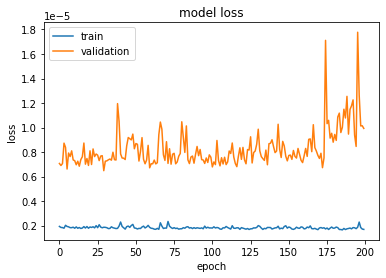

In [181]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [182]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

579.0561184201813

In [190]:
#Let's have a look at the 50 first rows to see how well we performed

comparaison=pd.concat([pd.DataFrame(prediction_unscaled).rename(columns={0:'prediction'}),pd.DataFrame(y_val).rename(columns={0:'y_val'})],axis=1)

#We add a new indicator, the absolute difference
comparaison['absolute_diff']=comparaison.apply(lambda x: (x['prediction']-x['y_val'])**2,axis=1)
comparaison.head(50)

,prediction,y_val,absolute_diff
0,69.960953,110,1603.125304
1,0.337949,0,0.114210
2,-0.453255,0,0.205440
3,16.759592,13,14.134532
4,0.351359,0,0.123453
5,0.048618,0,0.002364
6,0.273098,0,0.074583
7,-0.214559,3,10.333391
8,-0.148235,0,0.021974
9,-0.453255,2,6.018462


In [184]:
comparaison.describe()

,prediction,y_val,absolute_diff
count,11526.000000,11526.000000,1.152600e+04
mean,8.518891,8.973712,5.790561e+02
std,51.864639,49.614875,1.036217e+04
min,-13.170770,0.000000,8.241259e-08
25%,-0.453255,0.000000,2.054404e-01
50%,0.194038,0.000000,2.316902e-01
75%,2.431689,3.000000,4.584697e+00
max,2480.384766,2653.000000,5.737221e+05


In [185]:
comparaison['absolute_diff'].sum()/y_val.size

579.0561184201813

In [191]:
comparaison['prediction_rounded']=comparaison['prediction'].apply(lambda x: round(x))
comparaison['diff_rounded']=comparaison.apply(lambda x: (x['prediction_rounded']-x['y_val'])**2,axis=1)

In [187]:
#Let's have a look at how well we improved the model with this improvement
comparaison.describe()

,prediction,y_val,absolute_diff,prediction_rounded,diff_rounded
count,11526.000000,11526.000000,1.152600e+04,11526.000000,11526.000000
mean,8.518891,8.973712,5.790561e+02,8.681069,578.909509
std,51.864639,49.614875,1.036217e+04,51.835997,10358.703288
min,-13.170770,0.000000,8.241259e-08,-13.000000,0.000000
25%,-0.453255,0.000000,2.054404e-01,0.000000,0.000000
50%,0.194038,0.000000,2.316902e-01,0.000000,0.000000
75%,2.431689,3.000000,4.584697e+00,2.000000,4.000000
max,2480.384766,2653.000000,5.737221e+05,2480.000000,573049.000000


In [194]:
def no_negatives(x):
    if x<0:
        return 0
    return x
comparaison['prediction_no_negatives']=comparaison['prediction_rounded'].apply(lambda x: no_negatives(x))
comparaison['diff_no_negatives']=comparaison.apply(lambda x: (x['prediction_no_negatives']-x['y_val'])**2,axis=1)

In [195]:
#Let's have a look at how well we improved the model with this improvement
comparaison.describe()

,prediction,y_val,absolute_diff,prediction_rounded,diff_rounded,prediction_no_negatives,diff_no_negatives
count,11526.000000,11526.000000,1.152600e+04,11526.000000,11526.000000,11526.000000,11526.000000
mean,8.518891,8.973712,5.790561e+02,8.681069,578.909509,8.684539,578.873937
std,51.864639,49.614875,1.036217e+04,51.835997,10358.703288,51.835114,10358.705042
min,-13.170770,0.000000,8.241259e-08,-13.000000,0.000000,0.000000,0.000000
25%,-0.453255,0.000000,2.054404e-01,0.000000,0.000000,0.000000,0.000000
50%,0.194038,0.000000,2.316902e-01,0.000000,0.000000,0.000000,0.000000
75%,2.431689,3.000000,4.584697e+00,2.000000,4.000000,2.000000,4.000000
max,2480.384766,2653.000000,5.737221e+05,2480.000000,573049.000000,2480.000000,573049.000000


# New Model with 2 hidden layers

In [197]:
#4. Setting up the model
num_features=x.shape[1]
hidden_layers=x.shape[0]/(num_features+1)

new_model = Sequential()
new_model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
new_model.add(Dense(hidden_layers, activation='relu'))
new_model.add(Dense(hidden_layers, activation='relu'))
new_model.add(Dense(1, activation='linear'))
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_14 (Dense)             (None, 1589)              46081     
_________________________________________________________________
dense_15 (Dense)             (None, 1589)              2526510   
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 1590      
Total params: 2,574,993
Trainable params: 2,574,993
Non-trainable params: 0
_________________________________________________________________


In [205]:
epoch=150
batch=150

new_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

Epoch 1/150
185/185 [==============================] - 0s 2ms/step - loss: 1.7179e-06 - mse: 1.7179e-06 - mae: 5.1864e-04 - val_loss: 8.5063e-06 - val_mse: 8.5063e-06 - val_mae: 5.6022e-04
Epoch 2/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5437e-06 - mse: 1.5437e-06 - mae: 4.9452e-04 - val_loss: 8.6524e-06 - val_mse: 8.6524e-06 - val_mae: 6.2150e-04
Epoch 3/150
185/185 [==============================] - 0s 2ms/step - loss: 1.6078e-06 - mse: 1.6078e-06 - mae: 5.0499e-04 - val_loss: 8.3734e-06 - val_mse: 8.3734e-06 - val_mae: 5.6362e-04
Epoch 4/150
185/185 [==============================] - 0s 2ms/step - loss: 1.4384e-06 - mse: 1.4384e-06 - mae: 4.7912e-04 - val_loss: 8.4773e-06 - val_mse: 8.4773e-06 - val_mae: 7.2173e-04
Epoch 5/150
185/185 [==============================] - 0s 2ms/step - loss: 1.4692e-06 - mse: 1.4692e-06 - mae: 4.9821e-04 - val_loss: 8.9328e-06 - val_mse: 8.9328e-06 - val_mae: 5.6596e-04
Epoch 6/150
185/185 [==============================] - 

185/185 [==============================] - 0s 1ms/step - loss: 1.4264e-06 - mse: 1.4264e-06 - mae: 4.7730e-04 - val_loss: 1.1524e-05 - val_mse: 1.1524e-05 - val_mae: 6.6415e-04
Epoch 45/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5099e-06 - mse: 1.5099e-06 - mae: 5.0408e-04 - val_loss: 8.8362e-06 - val_mse: 8.8362e-06 - val_mae: 7.9485e-04
Epoch 46/150
185/185 [==============================] - 0s 1ms/step - loss: 1.6165e-06 - mse: 1.6165e-06 - mae: 4.9785e-04 - val_loss: 1.0163e-05 - val_mse: 1.0163e-05 - val_mae: 5.8929e-04
Epoch 47/150
185/185 [==============================] - 0s 1ms/step - loss: 1.6768e-06 - mse: 1.6768e-06 - mae: 4.8795e-04 - val_loss: 1.0967e-05 - val_mse: 1.0967e-05 - val_mae: 8.7905e-04
Epoch 48/150
185/185 [==============================] - 0s 1ms/step - loss: 2.0488e-06 - mse: 2.0488e-06 - mae: 5.7373e-04 - val_loss: 9.7983e-06 - val_mse: 9.7983e-06 - val_mae: 6.0715e-04
Epoch 49/150
185/185 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 2ms/step - loss: 1.6489e-06 - mse: 1.6489e-06 - mae: 5.0160e-04 - val_loss: 1.2488e-05 - val_mse: 1.2488e-05 - val_mae: 6.4450e-04
Epoch 88/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5803e-06 - mse: 1.5803e-06 - mae: 4.9453e-04 - val_loss: 1.8026e-05 - val_mse: 1.8026e-05 - val_mae: 7.5018e-04
Epoch 89/150
185/185 [==============================] - 0s 2ms/step - loss: 1.6865e-06 - mse: 1.6865e-06 - mae: 5.1728e-04 - val_loss: 1.5907e-05 - val_mse: 1.5907e-05 - val_mae: 7.4585e-04
Epoch 90/150
185/185 [==============================] - 0s 1ms/step - loss: 1.6372e-06 - mse: 1.6372e-06 - mae: 5.0730e-04 - val_loss: 1.5920e-05 - val_mse: 1.5920e-05 - val_mae: 6.3258e-04
Epoch 91/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5100e-06 - mse: 1.5100e-06 - mae: 4.9541e-04 - val_loss: 1.4062e-05 - val_mse: 1.4062e-05 - val_mae: 0.0011
Epoch 92/150
185/185 [==============================] - 0s 2ms/step

185/185 [==============================] - 0s 1ms/step - loss: 1.7215e-06 - mse: 1.7215e-06 - mae: 5.1553e-04 - val_loss: 9.8326e-06 - val_mse: 9.8326e-06 - val_mae: 6.1941e-04
Epoch 131/150
185/185 [==============================] - 0s 2ms/step - loss: 1.4753e-06 - mse: 1.4753e-06 - mae: 4.6547e-04 - val_loss: 8.1117e-06 - val_mse: 8.1117e-06 - val_mae: 7.5008e-04
Epoch 132/150
185/185 [==============================] - 0s 2ms/step - loss: 1.4730e-06 - mse: 1.4730e-06 - mae: 4.9118e-04 - val_loss: 8.7948e-06 - val_mse: 8.7948e-06 - val_mae: 5.8028e-04
Epoch 133/150
185/185 [==============================] - 0s 1ms/step - loss: 1.4494e-06 - mse: 1.4494e-06 - mae: 4.8879e-04 - val_loss: 1.0767e-05 - val_mse: 1.0767e-05 - val_mae: 6.1297e-04
Epoch 134/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5207e-06 - mse: 1.5207e-06 - mae: 5.3497e-04 - val_loss: 1.0106e-05 - val_mse: 1.0106e-05 - val_mae: 6.4428e-04
Epoch 135/150
185/185 [==============================] - 0s

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


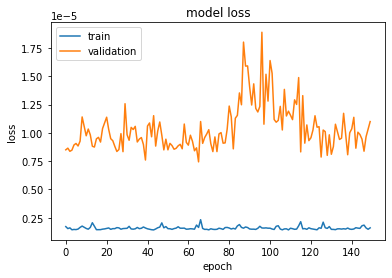

In [214]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [202]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

740.9120461477172

In [203]:
mean_absolute_error(y_val, prediction_unscaled)

4.730353311560731

In [204]:
mean_squared_error(y_val, prediction_unscaled)

740.9120461477172

# Simpler Model

In [350]:
#4. Setting up the model
num_features=x.shape[1]
hidden_layers=2/3*(num_features+1)

simpler_model = Sequential()
simpler_model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
simpler_model.add(Dense(hidden_layers, activation='relu'))
simpler_model.add(Dense(1, activation='linear'))
simpler_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_73 (Dense)             (None, 19)                551       
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 20        
Total params: 1,383
Trainable params: 1,383
Non-trainable params: 0
_________________________________________________________________


In [351]:
epoch=100
batch=int(x.shape[0]/7)

simpler_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=simpler_model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)
predictions = simpler_model.predict(xval_scale)

We tested with batch=int(x.shape[0]/50), and it resulted in overfitting, so with a dichotomy method, we landed at batch=int(x.shape[0]/7), which is 6586

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


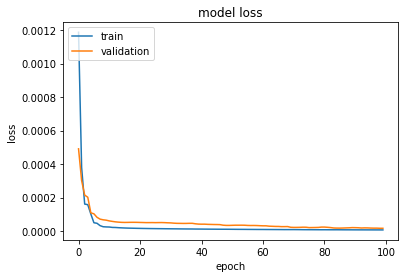

In [353]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [354]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

505.3003592731998

In [355]:
batch

6586

## Just for fun : Testing with a new batch value (much lower) ==> overfitting

In [243]:
epoch=100
batch=500

simpler_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=simpler_model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)
predictions = simpler_model.predict(xval_scale)

Epoch 1/100
56/56 [==============================] - 0s 3ms/step - loss: 1.3785e-05 - mse: 1.3785e-05 - mae: 0.0015 - val_loss: 1.7399e-05 - val_mse: 1.7399e-05 - val_mae: 0.0011
Epoch 2/100
56/56 [==============================] - 0s 1ms/step - loss: 1.0300e-05 - mse: 1.0300e-05 - mae: 0.0010 - val_loss: 1.7721e-05 - val_mse: 1.7721e-05 - val_mae: 0.0012
Epoch 3/100
56/56 [==============================] - 0s 1ms/step - loss: 1.0447e-05 - mse: 1.0447e-05 - mae: 0.0010 - val_loss: 1.8814e-05 - val_mse: 1.8814e-05 - val_mae: 0.0011
Epoch 4/100
56/56 [==============================] - 0s 1ms/step - loss: 9.4231e-06 - mse: 9.4231e-06 - mae: 9.2727e-04 - val_loss: 1.2165e-05 - val_mse: 1.2165e-05 - val_mae: 0.0013
Epoch 5/100
56/56 [==============================] - 0s 1ms/step - loss: 9.4648e-06 - mse: 9.4648e-06 - mae: 9.9298e-04 - val_loss: 9.9588e-06 - val_mse: 9.9588e-06 - val_mae: 9.1685e-04
Epoch 6/100
56/56 [==============================] - 0s 1ms/step - loss: 8.3571e-06 - mse: 8.

56/56 [==============================] - 0s 1ms/step - loss: 3.9736e-06 - mse: 3.9736e-06 - mae: 7.9807e-04 - val_loss: 1.8950e-05 - val_mse: 1.8950e-05 - val_mae: 0.0012
Epoch 46/100
56/56 [==============================] - 0s 1ms/step - loss: 4.8215e-06 - mse: 4.8215e-06 - mae: 0.0012 - val_loss: 2.0448e-05 - val_mse: 2.0448e-05 - val_mae: 8.8789e-04
Epoch 47/100
56/56 [==============================] - 0s 1ms/step - loss: 4.0413e-06 - mse: 4.0413e-06 - mae: 8.7179e-04 - val_loss: 2.1804e-05 - val_mse: 2.1804e-05 - val_mae: 0.0017
Epoch 48/100
56/56 [==============================] - 0s 1ms/step - loss: 5.0551e-06 - mse: 5.0551e-06 - mae: 0.0010 - val_loss: 1.5783e-05 - val_mse: 1.5783e-05 - val_mae: 8.1324e-04
Epoch 49/100
56/56 [==============================] - 0s 1ms/step - loss: 4.1154e-06 - mse: 4.1154e-06 - mae: 8.8641e-04 - val_loss: 1.3544e-05 - val_mse: 1.3544e-05 - val_mae: 0.0011
Epoch 50/100
56/56 [==============================] - 0s 1ms/step - loss: 3.7479e-06 - mse: 3

56/56 [==============================] - 0s 2ms/step - loss: 3.4566e-06 - mse: 3.4566e-06 - mae: 7.4686e-04 - val_loss: 2.2306e-05 - val_mse: 2.2306e-05 - val_mae: 0.0013
Epoch 90/100
56/56 [==============================] - 0s 2ms/step - loss: 3.3276e-06 - mse: 3.3276e-06 - mae: 8.1345e-04 - val_loss: 2.3099e-05 - val_mse: 2.3099e-05 - val_mae: 8.9092e-04
Epoch 91/100
56/56 [==============================] - 0s 1ms/step - loss: 3.4108e-06 - mse: 3.4108e-06 - mae: 8.6882e-04 - val_loss: 2.1191e-05 - val_mse: 2.1191e-05 - val_mae: 0.0011
Epoch 92/100
56/56 [==============================] - 0s 1ms/step - loss: 3.1566e-06 - mse: 3.1566e-06 - mae: 7.7133e-04 - val_loss: 2.1644e-05 - val_mse: 2.1644e-05 - val_mae: 9.1310e-04
Epoch 93/100
56/56 [==============================] - 0s 1ms/step - loss: 3.1977e-06 - mse: 3.1977e-06 - mae: 7.9962e-04 - val_loss: 2.1234e-05 - val_mse: 2.1234e-05 - val_mae: 8.1702e-04
Epoch 94/100
56/56 [==============================] - 0s 2ms/step - loss: 3.4459e

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


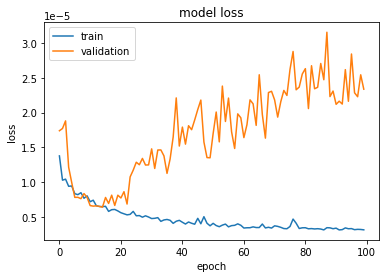

In [244]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [241]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

468.2364019079433

In [242]:
mean_absolute_error(y_val, prediction_unscaled)

4.835910759401304

# Je suis un encule

In [233]:
#4. Setting up the model
num_features=x.shape[1]
hidden_layers=2/3*(num_features+1)

simpler_model_two_hidden_layers = Sequential()
simpler_model_two_hidden_layers.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
simpler_model_two_hidden_layers.add(Dense(hidden_layers, activation='relu'))
simpler_model_two_hidden_layers.add(Dense(hidden_layers, activation='relu'))
simpler_model_two_hidden_layers.add(Dense(1, activation='linear'))
simpler_model_two_hidden_layers.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_21 (Dense)             (None, 19)                551       
_________________________________________________________________
dense_22 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 20        
Total params: 1,763
Trainable params: 1,763
Non-trainable params: 0
_________________________________________________________________


In [237]:
epoch=100
batch=x.shape[0]

simpler_model_two_hidden_layers.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=simpler_model_two_hidden_layers.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.2)
predictions = simpler_model_two_hidden_layers.predict(xval_scale)

Epoch 1/100
1/1 [==============================] - 0s 113ms/step - loss: 1.3882e-04 - mse: 1.3882e-04 - mae: 0.0090 - val_loss: 2.1381e-04 - val_mse: 2.1381e-04 - val_mae: 0.0062
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 8.7170e-05 - mse: 8.7170e-05 - mae: 0.0061 - val_loss: 1.8598e-04 - val_mse: 1.8598e-04 - val_mae: 0.0039
Epoch 3/100
1/1 [==============================] - 0s 19ms/step - loss: 6.2546e-05 - mse: 6.2546e-05 - mae: 0.0038 - val_loss: 1.7578e-04 - val_mse: 1.7578e-04 - val_mae: 0.0027
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 5.6422e-05 - mse: 5.6422e-05 - mae: 0.0026 - val_loss: 1.7370e-04 - val_mse: 1.7370e-04 - val_mae: 0.0031
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 5.8053e-05 - mse: 5.8053e-05 - mae: 0.0030 - val_loss: 1.7211e-04 - val_mse: 1.7211e-04 - val_mae: 0.0033
Epoch 6/100
1/1 [==============================] - 0s 21ms/step - loss: 5.9903e-05 - mse: 5.9903e-05 - mae: 0

Epoch 47/100
1/1 [==============================] - 0s 29ms/step - loss: 2.1377e-05 - mse: 2.1377e-05 - mae: 9.9868e-04 - val_loss: 6.4101e-05 - val_mse: 6.4101e-05 - val_mae: 0.0010
Epoch 48/100
1/1 [==============================] - 0s 20ms/step - loss: 2.1085e-05 - mse: 2.1085e-05 - mae: 9.9087e-04 - val_loss: 6.1607e-05 - val_mse: 6.1607e-05 - val_mae: 0.0010
Epoch 49/100
1/1 [==============================] - 0s 21ms/step - loss: 2.0843e-05 - mse: 2.0843e-05 - mae: 0.0010 - val_loss: 5.9233e-05 - val_mse: 5.9233e-05 - val_mae: 0.0011
Epoch 50/100
1/1 [==============================] - 0s 23ms/step - loss: 2.0613e-05 - mse: 2.0613e-05 - mae: 0.0010 - val_loss: 5.6949e-05 - val_mse: 5.6949e-05 - val_mae: 0.0011
Epoch 51/100
1/1 [==============================] - 0s 26ms/step - loss: 2.0428e-05 - mse: 2.0428e-05 - mae: 0.0010 - val_loss: 5.4750e-05 - val_mse: 5.4750e-05 - val_mae: 0.0011
Epoch 52/100
1/1 [==============================] - 0s 24ms/step - loss: 2.0283e-05 - mse: 2.0283

1/1 [==============================] - 0s 20ms/step - loss: 1.4426e-05 - mse: 1.4426e-05 - mae: 8.0481e-04 - val_loss: 2.7581e-05 - val_mse: 2.7581e-05 - val_mae: 8.0019e-04
Epoch 92/100
1/1 [==============================] - 0s 20ms/step - loss: 1.4292e-05 - mse: 1.4292e-05 - mae: 7.9603e-04 - val_loss: 2.6993e-05 - val_mse: 2.6993e-05 - val_mae: 8.1412e-04
Epoch 93/100
1/1 [==============================] - 0s 19ms/step - loss: 1.4191e-05 - mse: 1.4191e-05 - mae: 8.1037e-04 - val_loss: 2.6441e-05 - val_mse: 2.6441e-05 - val_mae: 8.2183e-04
Epoch 94/100
1/1 [==============================] - 0s 19ms/step - loss: 1.4104e-05 - mse: 1.4104e-05 - mae: 8.1841e-04 - val_loss: 2.5883e-05 - val_mse: 2.5883e-05 - val_mae: 8.1436e-04
Epoch 95/100
1/1 [==============================] - 0s 19ms/step - loss: 1.4007e-05 - mse: 1.4007e-05 - mae: 8.1162e-04 - val_loss: 2.5329e-05 - val_mse: 2.5329e-05 - val_mae: 7.9492e-04
Epoch 96/100
1/1 [==============================] - 0s 18ms/step - loss: 1.389

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


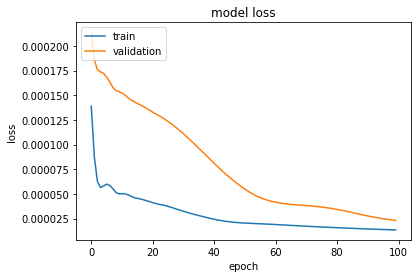

In [238]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [239]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

501.6009667487024

# En dessous de ça on s'en balec

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


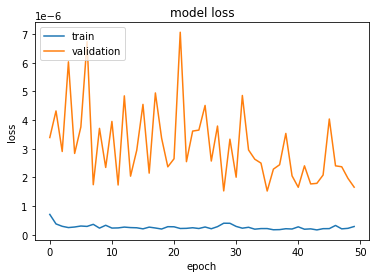

In [99]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


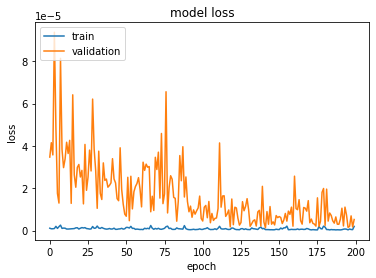

In [93]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


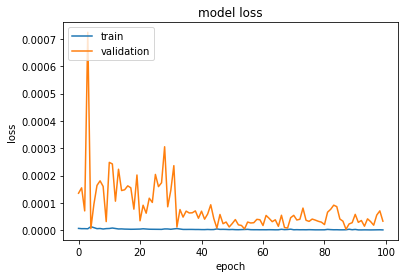

In [91]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


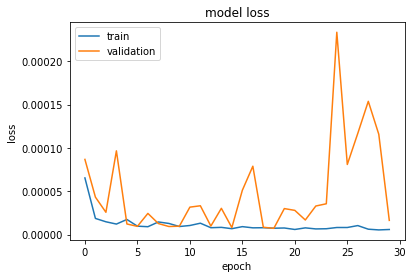

In [39]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [100]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

262.723082996859

In [95]:
comparaison=pd.concat([pd.DataFrame(prediction_unscaled).rename(columns={0:'prediction'}),pd.DataFrame(y_val).rename(columns={0:'y_val'})],axis=1)

comparaison['absolute_diff']=comparaison.apply(lambda x: (x['prediction']-x['y_val'])**2,axis=1)
comparaison['relative_diff']=comparaison.apply(lambda x: x['absolute_diff']/(x['prediction']**2),axis=1)
comparaison.head()

,prediction,y_val,absolute_diff,relative_diff
0,141.599411,110,998.522776,0.049801
1,-0.141118,0,0.019914,1.000000
2,-0.141118,0,0.019914,1.000000
3,17.675032,13,21.855921,0.069960
4,-0.141118,0,0.019914,1.000000


In [96]:
comparaison.describe()

,prediction,y_val,absolute_diff,relative_diff
count,11526.000000,11526.000000,1.152600e+04,1.152600e+04
mean,9.712377,8.973712,4.149077e+02,1.013425e+02
std,62.783829,49.614875,1.574335e+04,5.956349e+03
min,-25.213772,0.000000,2.260115e-07,3.433703e-09
25%,-0.141118,0.000000,1.991431e-02,6.468449e-02
50%,-0.141118,0.000000,1.991431e-02,1.000000e+00
75%,2.796188,3.000000,6.021014e-01,1.000000e+00
max,3379.122314,2653.000000,1.418173e+06,5.883183e+05


In [150]:
comparaison['absolute_diff'].sum()/y_val.size

135.70134429570572

11526

# Research

In [11]:
#Could be a solution to solve the categorisation problem

df=pd.read_csv("./challenge_youtube_toxic.csv", sep=";",encoding = 'latin1')

categ_inst=df.categ_inst.astype("category").cat.codes
categ_inst=pd.Series(categ_inst)
categ_inst.unique()

array([4, 5, 3, 2, 1, 0], dtype=int8)

# Best Tuto ever pour Prediction Neural Network : https://towardsdatascience.com/regression-based-neural-networks-with-tensorflow-v2-0-predicting-average-daily-rates-e20fffa7ac9a

In [127]:
#5. Using the model
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=model.fit(xtrain_scale, ytrain_scale, epochs=50, batch_size=150, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

Epoch 1/50
185/185 [==============================] - 0s 2ms/step - loss: 1.9528e-07 - mse: 1.9528e-07 - mae: 2.0972e-04 - val_loss: 7.7847e-06 - val_mse: 7.7847e-06 - val_mae: 3.0627e-04
Epoch 2/50
185/185 [==============================] - 0s 1ms/step - loss: 2.3775e-07 - mse: 2.3775e-07 - mae: 2.1955e-04 - val_loss: 7.5658e-06 - val_mse: 7.5658e-06 - val_mae: 2.0531e-04
Epoch 3/50
185/185 [==============================] - 0s 1ms/step - loss: 1.6042e-07 - mse: 1.6042e-07 - mae: 1.8620e-04 - val_loss: 8.4396e-06 - val_mse: 8.4396e-06 - val_mae: 2.5011e-04
Epoch 4/50
185/185 [==============================] - 0s 1ms/step - loss: 1.2152e-07 - mse: 1.2152e-07 - mae: 1.6218e-04 - val_loss: 5.8213e-06 - val_mse: 5.8213e-06 - val_mae: 2.1067e-04
Epoch 5/50
185/185 [==============================] - 0s 1ms/step - loss: 1.7923e-07 - mse: 1.7923e-07 - mae: 1.8849e-04 - val_loss: 7.8779e-06 - val_mse: 7.8779e-06 - val_mae: 3.1747e-04
Epoch 6/50
185/185 [==============================] - 0s 1ms